### Copyright 2022 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## A* pathfinding algorithm

## Global variables for storing information

In [1]:
import numpy as np
pq_index_dict = {}
AMT_ROWS = 7
AMT_COLS = 7
DEFAULT_KEY = ''
HEURISTIC_BIAS = False
grid = None
global_target = None
grid_states = []
color_states = [[]] # List of lists

## Data structure to store data of each node/cell

In [2]:
class Cell():
    def __init__(self, row_input, col_input):
        self.key = DEFAULT_KEY # Key is used for printing data
        self.row = row_input
        self.col = col_input
        self.current_distance = float('inf') # Positive infinity
        self.est_total_distance = float('inf')
        self.predecessor = 'NIL'
        self.visited = False
        self.is_obstacle = False
    
    def manhattan_distance_to(self, a):
        return (abs(self.row - a.row) + abs(self.col - a.col))

    def get_adjacent_cells(self):
        # Get top coordinate
        if self.row-1 < 0:
            top = None
        else:
            top = grid[self.row-1][self.col]
            if top.is_obstacle or top.visited:
                top = None
        # Get right coordinate
        if self.col+1 > AMT_COLS-1:
            right = None
        else:
            right = grid[self.row][self.col+1]
            if right.is_obstacle or right.visited:
                right = None
        # Get bottom coordinate
        if self.row+1 > AMT_ROWS-1:
            bottom = None
        else:
            bottom = grid[self.row+1][self.col]
            if bottom.is_obstacle or bottom.visited:
                bottom = None
        # Get left coordinate
        if self.col-1 < 0:
            left = None
        else:
            left = grid[self.row][self.col-1]
            if left.is_obstacle or left.visited:
                left = None
        # Insert them into a list of tuples if the value is able to be visited
        adjacencylist = []
        if top != None:
            adjacencylist.append(top)
        if right != None:
            adjacencylist.append(right)
        if bottom != None:
            adjacencylist.append(bottom)
        if left != None:
            adjacencylist.append(left)
        return adjacencylist

## Create a 2-D numpy array to store the cell info

In [3]:
def create_grid():
    global grid
    local_grid = []
    for row in range(AMT_ROWS):
        local_row = []
        for col in range(AMT_COLS):
            local_row.append(Cell(row, col))
        local_grid.append(local_row)
    grid = np.array(local_grid)

## Data structure for min priority queue elements

In [4]:
class PQ_Node():
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.prio = float('inf') # Positive infinity

## Implementation of a min priority queue

In [5]:
import copy
class PriorityQueue():
    def __init__(self):
        self.elements = []
        self.heapsize = 0
        for row in range(AMT_ROWS):
            for col in range(AMT_COLS):
                if not grid[row][col].is_obstacle:
                    self.elements.append(PQ_Node(row, col))  
                    pq_index_dict[str(row) + '.' + str(col)] = self.heapsize
                    self.heapsize += 1

    def is_empty(self):
        return self.heapsize == 0
            
    def parent(self, i):
        return (i-1)//2

    def left(self, i):
        return 2*i+1

    def right(self, i):
        return 2*i+2

    def heap_decrease_key(self, i, prio_input):
        self.elements[i].prio = prio_input   
        # If HEURISTIC_BIAS was set to True, then values with the same estimated total distance are not necessarily ordered in FIFO order (default) but instead ascending according to the heuristic value.
        # Of two compared values with same estimated total distance, the one with the lower heuristic is preferred as it would be physically closer to the target 
        # and therefore more likely to be on the right way. This makes the route more narrow and precise, whereas by default many unnecessary cells will be visited either way (with 8x8 grid or smaller).
        # Making the default more akin to Dijkstra's algorithm than a "smarter version of it"
        
        # Essentially: a node with current distance 6, heuristic 3 would be preferred over a node with current distance 4, heuristic 5.
        # A node with current distance 7, heuristic 3 would on the other hand not be preferred over a node with current distance 4, heuristic 5,
        # as the bias is only applied when estimated total distance of both nodes is equal.
        
        # To compare it with this bias in mind, I wrote my own comparison method "is_smaller()" below
        if HEURISTIC_BIAS:
            
            while i > 0 and self.is_smaller(self.elements[i], self.elements[self.parent(i)]):
                self.elements[i], self.elements[self.parent(i)] = self.elements[self.parent(i)], self.elements[i]
                pq_index_dict[str(self.elements[i].row) + '.' + str(self.elements[i].col)] = i
                pq_index_dict[str(self.elements[self.parent(i)].row) + '.' + str(self.elements[self.parent(i)].col)] = self.parent(i)
                i = self.parent(i)

        else:
            while i > 0 and self.elements[self.parent(i)].prio > self.elements[i].prio:
                self.elements[i], self.elements[self.parent(i)] = self.elements[self.parent(i)], self.elements[i]
                pq_index_dict[str(self.elements[i].row) + '.' + str(self.elements[i].col)] = i
                pq_index_dict[str(self.elements[self.parent(i)].row) + '.' + str(self.elements[self.parent(i)].col)] = self.parent(i)
                i = self.parent(i)
            
    def extract_min(self):   
        min_element = copy.deepcopy(self.elements[0])
        self.heapsize -= 1
        self.elements[0], self.elements[self.heapsize] = self.elements[self.heapsize], self.elements[0] # Swaps first element and last element to delete the previous first and bubble down the previous last
        pq_index_dict[str(self.elements[0].row) + '.' + str(self.elements[0].col)] = 0
        pq_index_dict[str(self.elements[self.heapsize].row) + '.' + str(self.elements[self.heapsize].col)] = self.heapsize
        self.elements = self.elements[:self.heapsize] # Deletes last element
        self.min_heapify(0)
        return grid[min_element.row][min_element.col]

    def min_heapify(self, i):
        l = self.left(i)
        r = self.right(i)   
        if HEURISTIC_BIAS:
            if l < self.heapsize and self.is_smaller(self.elements[l], self.elements[i]):
                minimum = l
            else:
                minimum = i       
            if r < self.heapsize and self.is_smaller(self.elements[r], self.elements[minimum]):
                minimum = r   
        else:
            if l < self.heapsize and self.elements[l].prio < self.elements[i].prio:
                minimum = l
            else:
                minimum = i       
            if r < self.heapsize and self.elements[r].prio < self.elements[minimum].prio:
                minimum = r  
        if minimum != i:
            self.elements[i], self.elements[minimum] = self.elements[minimum], self.elements[i]
            pq_index_dict[str(self.elements[i].row) + '.' + str(self.elements[i].col)] = i
            pq_index_dict[str(self.elements[minimum].row) + '.' + str(self.elements[minimum].col)] = minimum
            self.min_heapify(minimum)
    
    
    def reduce_est_total_distance(self, u, prio_input):   
        # Update in grid
        grid[u.row][u.col].est_total_distance = prio_input
        grid[u.row][u.col].key = prio_input
        # Update in priority queue
        corresponding_index = pq_index_dict[str(u.row) + '.' + str(u.col)]
        self.heap_decrease_key(corresponding_index, prio_input)
        
    def is_smaller(self, el1, el2):
        # Check if element 1 should be the parent of element 2 in min priority queue
        # See heap_decrease_key() function for an explanation as to why
        if el1.prio != el2.prio:
            if el1.prio < el2.prio:
                return True
            else:
                return False
        else:
            el1_grid = grid[el1.row][el1.col]
            el2_grid = grid[el2.row][el2.col]
            
            el1_heuristic = el1_grid.manhattan_distance_to(global_target)
            el2_heuristic = el2_grid.manhattan_distance_to(global_target)
            
            if el1_heuristic < el2_heuristic:
                return True
            else:
                return False

## A* implementation

In [6]:
def a_star(start, target):
    global global_target, color_states
    global_target = target
    Q = PriorityQueue()
    start.current_distance = 0
    start.predecessor = 'NIL'
    Q.reduce_est_total_distance(start, 0 + start.manhattan_distance_to(target))
    start.key = 'S'
    target.key = 'T'
    while not Q.is_empty():
        u = Q.extract_min()
        if u.get_adjacent_cells() != None:
            save_state()
            color_states.append([u.row, u.col])
        u.visited = True
        if u == target:
            break
        for ν in u.get_adjacent_cells():
            if not ν.visited and not ν.is_obstacle:
                if ν.current_distance > u.current_distance + 1:
                    ν.current_distance = u.current_distance + 1
                    Q.reduce_est_total_distance(ν, ν.current_distance + ν.manhattan_distance_to(target))
                    ν.predecessor = u

## Function to save the grid's states

In [7]:
import copy
def save_state():
    global grid_states
    grid_states.append(copy.deepcopy(grid))

## Output colors

In [8]:
# Defaults are: 'forestgreen', 'red', 'black', 'white', 'white', 'cool'
COL_START = 'forestgreen'
COL_TARGET = 'red'
COL_OBSTACLE = 'black'
COL_DISCOVERED = 'white'
COL_UNDISCOVERED = 'white'
COL_GRADIENT = 'cool'
# Link with all avaiable colormaps: https://matplotlib.org/stable/gallery/color/colormap_reference.html
# If you want to reverse a gradient (mirror along Y-axis), add '_r' to the name.
# The reversed version of 'cool', would then be 'cool_r'

## Constants for visualizing the grid

In [9]:
X_MIN_HLINES = 1.5
Y_MIN_VLINES = 1.5
OFFSET = 0.5
OFFSET_FOR_CORNER_VALUES = 0.25
DESIRED_SIZE_X = 12 # Same for x and y
DESIRED_SIZE_Y = 12

## Visualizing the grid

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def visualize(local_grid, index):
    fig, ax = plt.subplots()
    fig.set_size_inches(DESIRED_SIZE_X, DESIRED_SIZE_Y) 
    ax.axis([0, AMT_ROWS+1, 0, AMT_COLS+1])
    ax.axis('off')
    # Plot the horizontal lines and the digits indictating each row
    for row in range(AMT_ROWS):
        # Vertical numbers to the left
        plt.text(x=0, y=row+1, s=str(row+1), fontsize=16, verticalalignment='center', horizontalalignment='center')
        # Vertical numbers to the right
        plt.text(x=AMT_COLS+1, y=row+1, s=str(row+1), fontsize=16, verticalalignment='center', horizontalalignment='center')
        plt.hlines(xmin=OFFSET, xmax=AMT_COLS+OFFSET, y=row+OFFSET, color='k', linewidth=3)
    # Last horizontal line (the one to the very right) has to be plotted on its own as there is no text pair to go with it
    plt.hlines(xmin=OFFSET, xmax=AMT_COLS+OFFSET, y=AMT_ROWS+OFFSET, color='k', linewidth=3)
    # Plot the vertical lines and the letters indicating columns
    for col in range(AMT_COLS):
        # Horizontal letters at the bottom
        plt.text(x=col+1, y=0, s=chr(65+col), fontsize=16, verticalalignment='center', horizontalalignment='center')
        # Horizontal letters at the top
        plt.text(x=col+1, y=AMT_ROWS+1, s=chr(65+col), fontsize=16, verticalalignment='center', horizontalalignment='center')
        plt.vlines(x=col+OFFSET, ymin=OFFSET, ymax=AMT_ROWS+OFFSET, color='k')
    # Last vertical line is added seperately
    plt.vlines(x=AMT_COLS+OFFSET, ymin=OFFSET, ymax=AMT_ROWS+OFFSET, color='k')
    
    ################### Actual content ###################
    
    # If this function is called with index -1, then the function is supposed to print the result path.
    # Otherwise it should print the grids noramlly
    if index != -1:
        COLORMAP = plt.colormaps[COL_GRADIENT]
        colordict = get_color_data(index)
        for row in reversed(range(AMT_ROWS)):
            for col in range(AMT_COLS):
                # actual_data_row is the row value being mirrored along the x axis.
                # It is used to access the actual element data as the np array row indices increase from top to bottom while the axis in matplotlib (Quadrant 1) increases from bottom to top.
                actual_data_row = AMT_ROWS - row - 1
                if local_grid[actual_data_row][col].key == 'S':
                    rect_color = COL_START
                elif local_grid[actual_data_row][col].key == 'T' or local_grid[actual_data_row][col].manhattan_distance_to(global_target) == 0:
                    rect_color = COL_TARGET
                elif local_grid[actual_data_row][col].is_obstacle == True:
                    rect_color = COL_OBSTACLE
                # Discovered but not visisted
                elif local_grid[actual_data_row][col].visited == False and local_grid[actual_data_row][col].key != DEFAULT_KEY:
                    #rect_color = 'yellow'
                    rect_color = COL_DISCOVERED
                # Undiscovered
                elif local_grid[actual_data_row][col].key == DEFAULT_KEY:
                    rect_color = COL_UNDISCOVERED
                # Visited
                else:
                    rect_color = COLORMAP(colordict[str(actual_data_row) + '.' + str(col)])
                # Now that the color of each square is known, it can be drawn
                rect = plt.Rectangle((col-OFFSET+1, row-OFFSET+1), 1, 1, facecolor=rect_color, edgecolor=None, linewidth=1, alpha=0.5)
                # If the current square-key is not a string (is not "S", "T", "X" or empty),
                # then you would want to display all 3 kinds of distances.
                if not isinstance(local_grid[actual_data_row][col].key, str):
                    # Distance until now
                    plt.text(x=col+1-OFFSET_FOR_CORNER_VALUES, y=row+1+OFFSET_FOR_CORNER_VALUES, s=str(local_grid[actual_data_row][col].current_distance),
                        fontsize=16, verticalalignment='center', horizontalalignment='center')
                    # Heuristic until target
                    plt.text(x=col+1+OFFSET_FOR_CORNER_VALUES, y=row+1+OFFSET_FOR_CORNER_VALUES, s=str(local_grid[actual_data_row][col].manhattan_distance_to(global_target)),
                        fontsize=16, verticalalignment='center', horizontalalignment='center')
                    # Total estimated distance left
                    plt.text(x=col+1-OFFSET_FOR_CORNER_VALUES, y=row+1-OFFSET_FOR_CORNER_VALUES, s=str(local_grid[actual_data_row][col].est_total_distance),
                        fontsize=16, verticalalignment='center', horizontalalignment='center')
                # If the current square-key is a string (those mentioned above), then only display the key
                else:
                    plt.text(x=col+1, y=row+1, s=str(local_grid[actual_data_row][col].key),
                        fontsize=16, verticalalignment='center', horizontalalignment='center')
                # Adds the rectangle onto the image
                ax.add_patch(rect)
    # This is for the case, where you only want the result path
    else:
        # Basically the dictionary only has defined values for squares which are in the path from start to target.
        # Meaning that if squares_in_path_dict.get(x) were to return None, then x is not part of the path
        # It also does not matter what corresponding value x gets in the hashmap. It is only of interest, that it has one
        squares_in_path_dict = get_squares_in_path()
        for row in reversed(range(AMT_ROWS)):
            for col in range(AMT_COLS):
                actual_data_row = AMT_ROWS - row - 1
                if local_grid[actual_data_row][col].key == 'S':
                    rect_color = COL_START
                    plt.text(x=col+1, y=row+1, s='S',
                        fontsize=16, verticalalignment='center', horizontalalignment='center')
                elif local_grid[actual_data_row][col].is_obstacle == True:
                    rect_color = COL_OBSTACLE
                    plt.text(x=col+1, y=row+1, s='X',
                        fontsize=16, verticalalignment='center', horizontalalignment='center')
                elif squares_in_path_dict.get(str(actual_data_row) + '.' + str(col)) != None:
                    rect_color = COL_TARGET
                    if actual_data_row == global_target.row and col == global_target.col:
                        plt.text(x=col+1, y=row+1, s='T',
                            fontsize=16, verticalalignment='center', horizontalalignment='center')
                else:
                    rect_color = COL_UNDISCOVERED
                rect = plt.Rectangle((col-OFFSET+1, row-OFFSET+1), 1, 1, facecolor=rect_color, edgecolor=None, linewidth=1, alpha=0.5)
                ax.add_patch(rect)
    plt.show()

## Function to return the squares which are part of the final path from start to target

In [11]:
def get_squares_in_path():
    squares_in_path_dict = {}
    # Mark the squares in the path by assigning them any value in the dictionary
    squares_in_path_dict[str(global_target.row) + '.' + str(global_target.col)] = True
    curr_node = global_target
    while curr_node.predecessor != 'NIL':
        curr_node = curr_node.predecessor
        squares_in_path_dict[str(curr_node.row) + '.' + str(curr_node.col)] = True
    return squares_in_path_dict

## Turn human-readable square names like "D5" to index equivalents

In [12]:
# Function for example to turn ("D5" to the corresponding coordinates in the numpy array "grid")
def turn_name_to_cords(name_of_square):
    col_number = int(ord(name_of_square[0])-65)
    row_number = AMT_ROWS - int(name_of_square[1])
    return row_number, col_number

## Functions to set start, target and obstacle cells

In [13]:
def set_start_target(start_name, target_name):
    s_row, s_col = turn_name_to_cords(start_name)
    t_row, t_col = turn_name_to_cords(target_name)
    if not (0 <= s_row <= AMT_ROWS-1) or not (0 <= s_col <= AMT_COLS-1):
        print("Invalid start")
        return None, None
    if not (0 <= t_row <= AMT_ROWS-1) or not (0 <= t_col <= AMT_COLS-1):
        print("Invalid target")
        return None, None
    return grid[s_row][s_col], grid[t_row][t_col]

In [14]:
def set_obstacles(obstacles):
    for obstacle in obstacles:
        row_number, col_number = turn_name_to_cords(obstacle)
        grid[row_number][col_number].is_obstacle = True
        grid[row_number][col_number].key = 'X'

## Calculate which color of the gradient each square is supposed to get

In [15]:
def get_color_data(index):
    # The dictionary will provide a number between 0 and 1, when row and columns of a given square are input as a string seperated by "."
    colordict = {}
    squares_in_gradient = []
    squares_in_gradient_colors = []
    # Basically append all the coordinates of values, which should be colored to the list
    for i in range(2, index+1):
        squares_in_gradient.append([color_states[i][0], color_states[i][1]])
    # Only calculate if you do not divide by 0.
    if len(squares_in_gradient)-1 > 0:
        step_length = 1 / (len(squares_in_gradient)-1)
        for i in range(0, len(squares_in_gradient)):
            squares_in_gradient_colors.append(i * step_length)
    # If there is only one square given a color, give him 100% color (the rightmost color of the gradient)
    else:
        squares_in_gradient_colors = [1]
    # The result are two lists. One containing the row and column of an element, which should receive a color on the gradient
    # The second one is the corresponding value from 0 to 1, which is then mapped onto the gradient in the visualize function
    for color_index, square_in_gradient in enumerate(squares_in_gradient):
        colordict[str(square_in_gradient[0]) + '.' + str(square_in_gradient[1])] = squares_in_gradient_colors[color_index]
    return colordict

## Legend for output

In [16]:
X_MAX = 7
Y_MAX = 7
def show_legend():
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    ax.axis([0, X_MAX, 0, Y_MAX])
    ax.axis('off')
    plt.text(x=2+OFFSET, y=Y_MAX, s='Legend',
            fontsize=20, verticalalignment='center', horizontalalignment='center')
    names = ["Start", "Target", "Obstacle", "Discovered", "Undiscovered"]
    colors = [COL_START, COL_TARGET, COL_OBSTACLE, COL_DISCOVERED, COL_UNDISCOVERED]
    for i in range(0, len(colors)):
        rect = plt.Rectangle((1-OFFSET, Y_MAX-1-i-OFFSET), 1, 1, facecolor=colors[i], edgecolor='black', linewidth=1, alpha=0.5)
        ax.add_patch(rect)
        plt.text(x=3, y=Y_MAX-1-i, s=names[i],
            fontsize=16, verticalalignment='center', horizontalalignment='center')
        if names[i] == "Start":
            plt.text(x=1, y=Y_MAX-1-i, s="S", fontsize=16, verticalalignment='center', horizontalalignment='center')
        elif names[i] == "Target":
            plt.text(x=1, y=Y_MAX-1-i, s="T", fontsize=16, verticalalignment='center', horizontalalignment='center')
        elif names[i] == "Obstacle":
            plt.text(x=1, y=Y_MAX-1-i, s="X", fontsize=16, verticalalignment='center', horizontalalignment='center')
        elif names[i] == "Discovered":
            # Distance until now
            plt.text(x=1-OFFSET/2, y=Y_MAX-1-i+OFFSET/2, s="a", fontsize=16, verticalalignment='center', horizontalalignment='center')
            plt.text(x=5-OFFSET/2, y=Y_MAX-1-i+OFFSET/2, s="a = Distance until now", fontsize=16, verticalalignment='bottom', horizontalalignment='left')
            # Heuristic until target
            plt.text(x=1+OFFSET/2, y=Y_MAX-1-i+OFFSET/2, s="b", fontsize=16, verticalalignment='center', horizontalalignment='center')
            plt.text(x=5-OFFSET/2, y=Y_MAX-1-i+OFFSET/2-0.5, s="b = Heuristic (Manhattan distance)", fontsize=16, verticalalignment='center', horizontalalignment='left')
            # Total estimated distance left
            plt.text(x=1-OFFSET/2, y=Y_MAX-1-i-OFFSET+OFFSET/2, s="c", fontsize=16, verticalalignment='center', horizontalalignment='center')
            plt.text(x=5-OFFSET/2, y=Y_MAX-1-i+OFFSET/2-1, s="c = Total estimated distance", fontsize=16, verticalalignment='top', horizontalalignment='left')
    plt.text(x=2, y=1-OFFSET, 
             s="""The color of the squares, which were already visited, changes.\n
             Each square's color indicates when it was visited relative to the other squares.\n
             The more recent the square, the more the color is to the right side of the gradient\n
             The currently used gradient is shown below. Like all other colors, it is configurable.""",
            fontsize=16, verticalalignment='center', horizontalalignment='center')
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    ax.imshow(gradient, aspect=7, cmap=plt.colormaps[COL_GRADIENT])
    ax.set_axis_off()

## Adjust grid size and HEURISTIC_BIAS here

In [17]:
AMT_ROWS = 7
AMT_COLS = 7

# For an in-depth explanation of what HEURISTIC_BIAS does, see the source code of the priority queue implementation in the fifth Jupyter Notebook-cell
# It basically is an optimization to make the algorithm behave "smarter" when dealing with grids such as here.
# If you want, you can set it to "False" here and observe the difference
HEURISTIC_BIAS = True

## Example

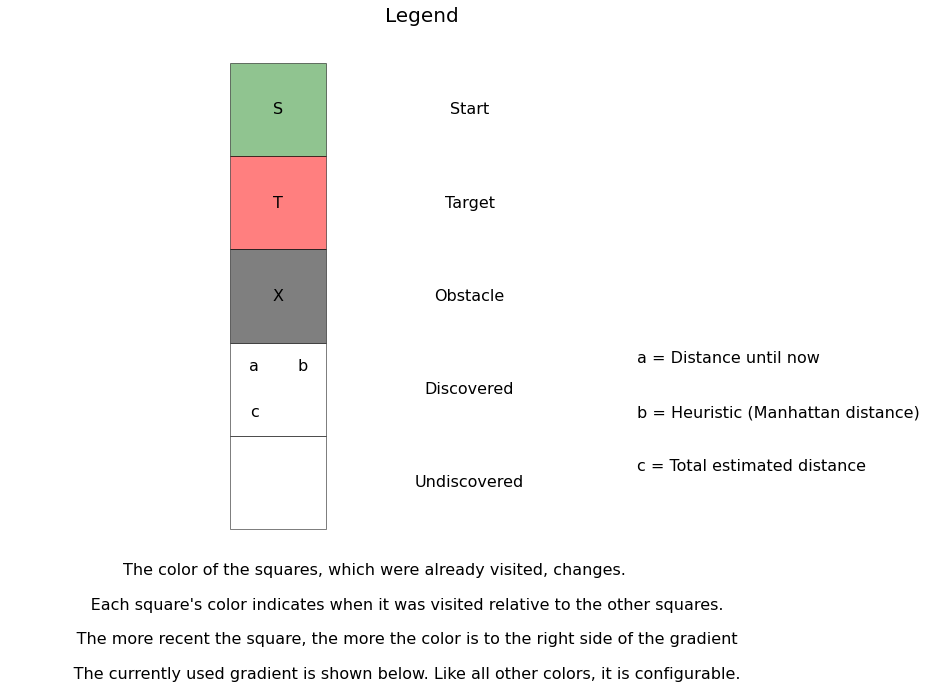

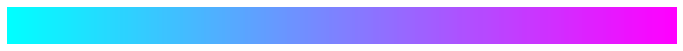

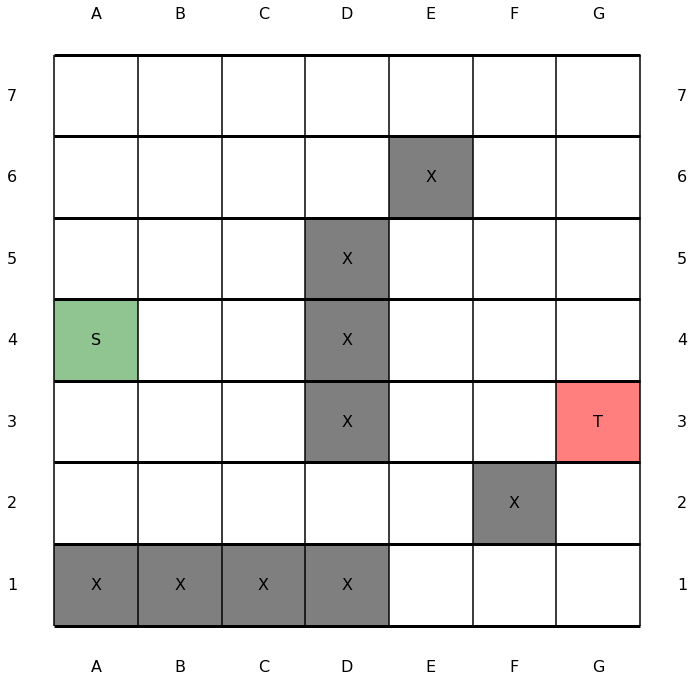

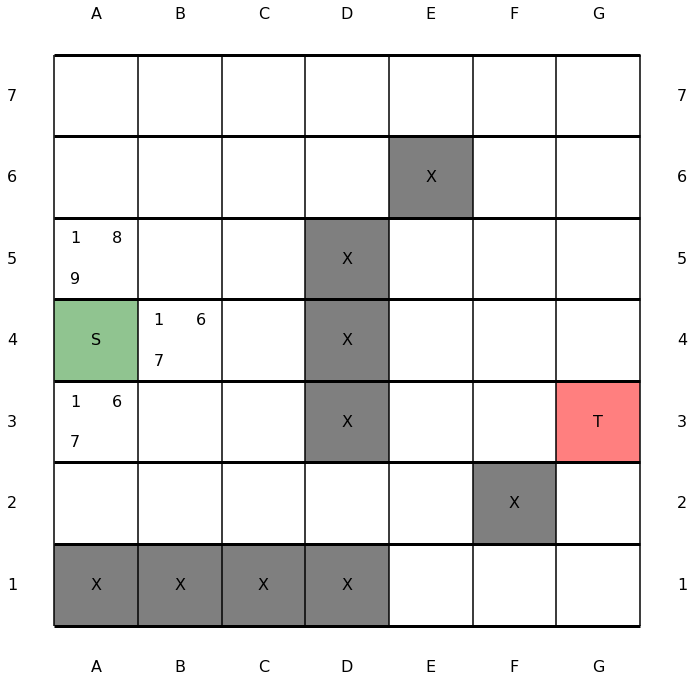

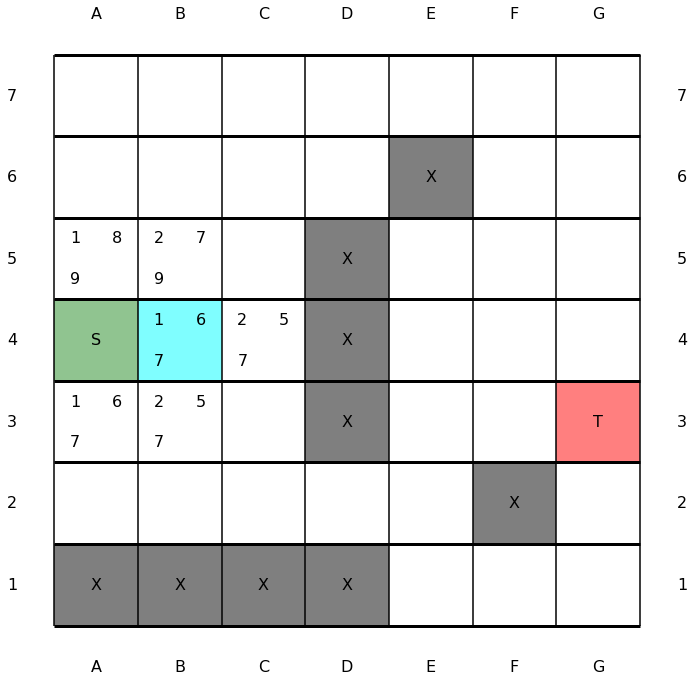

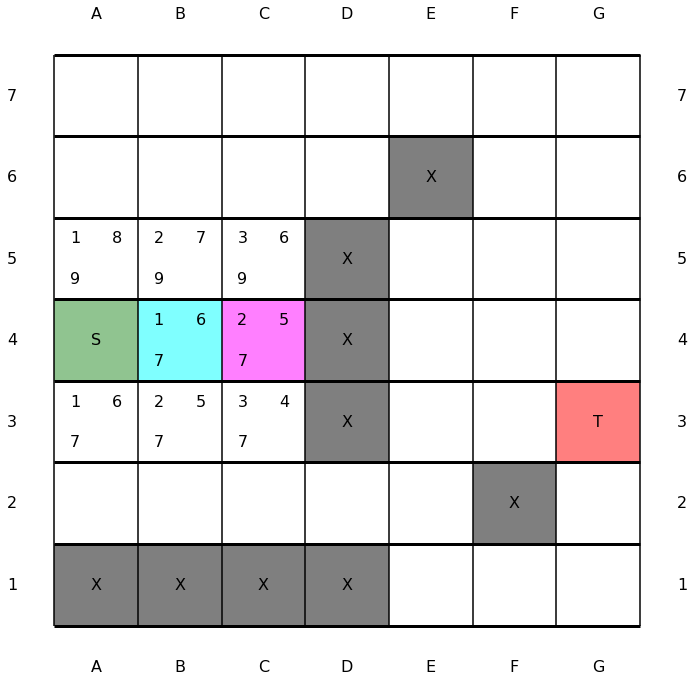

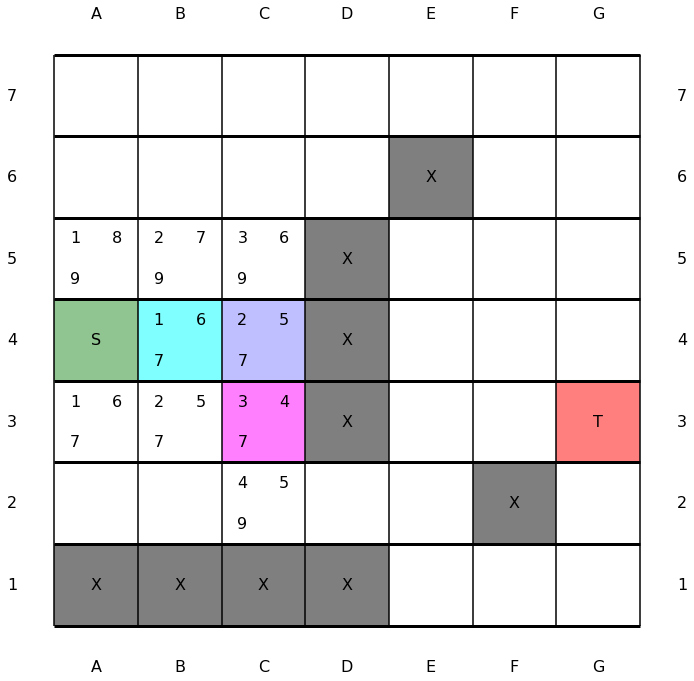

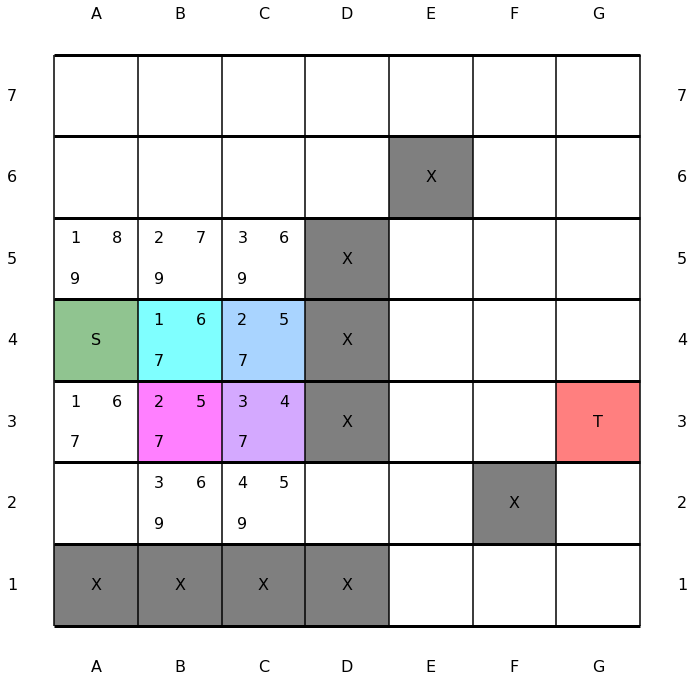

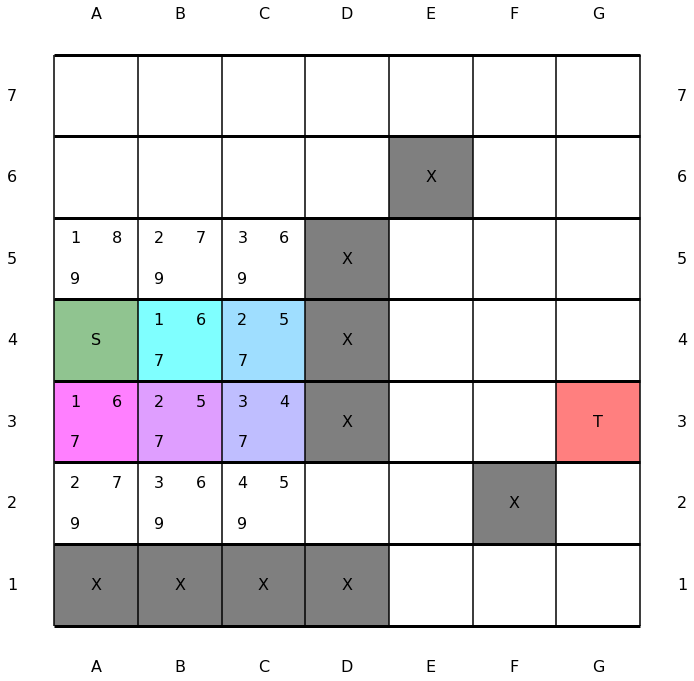

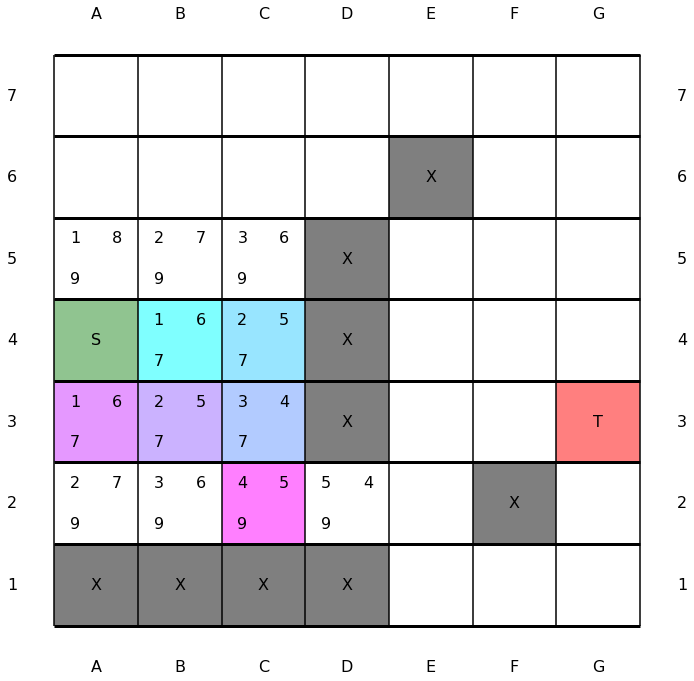

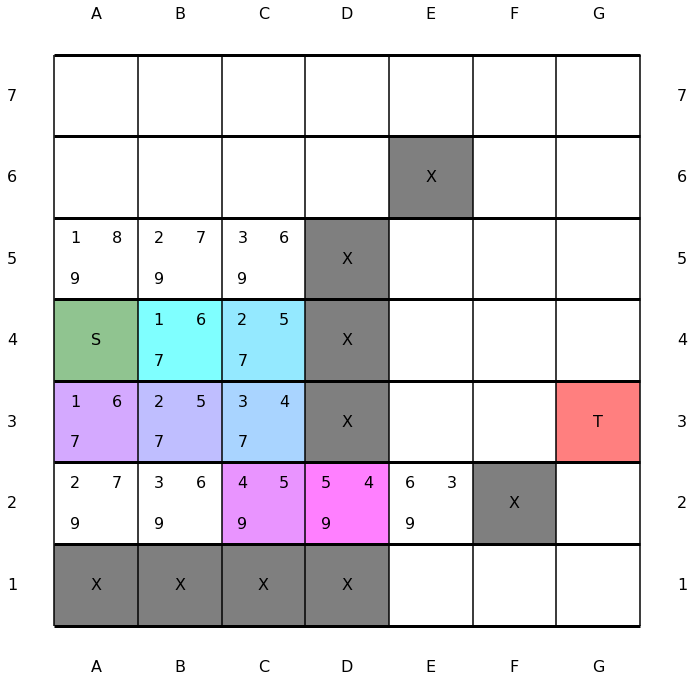

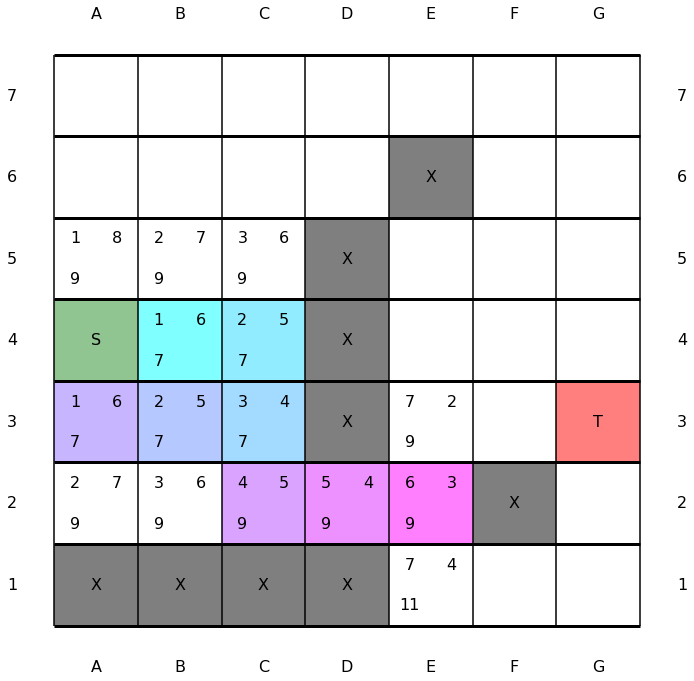

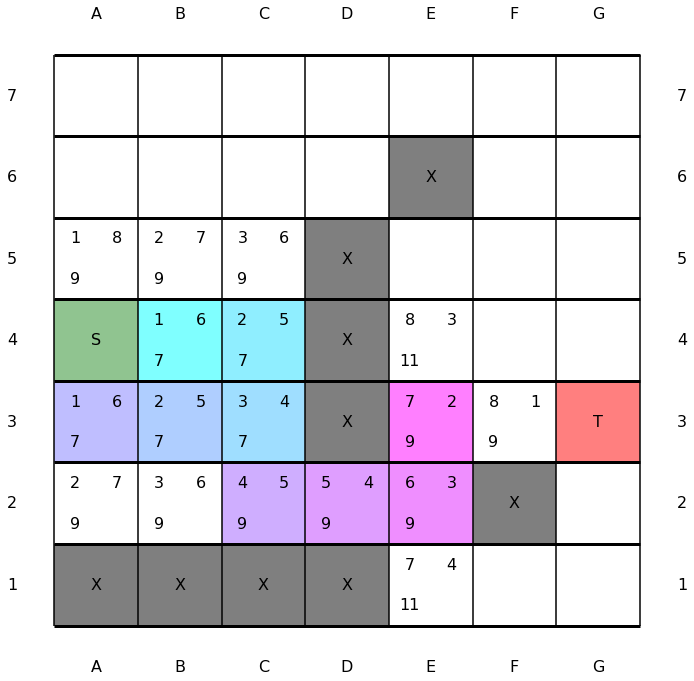

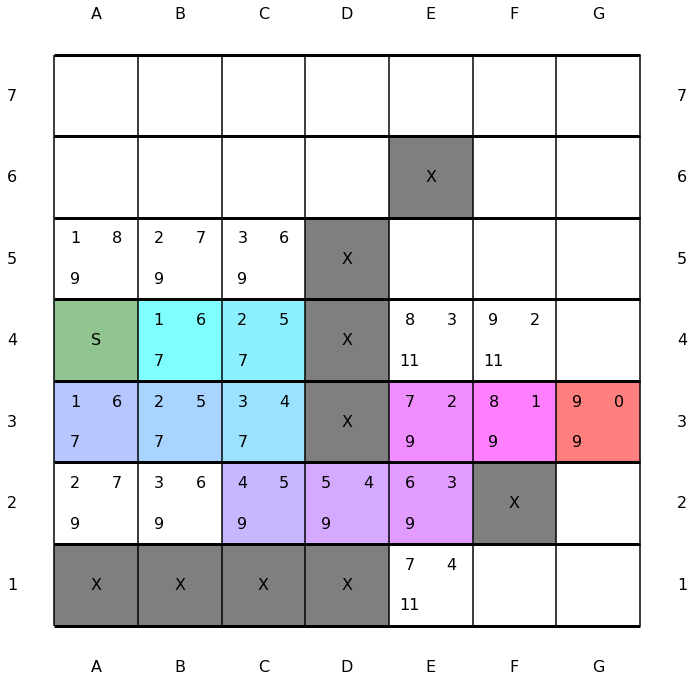

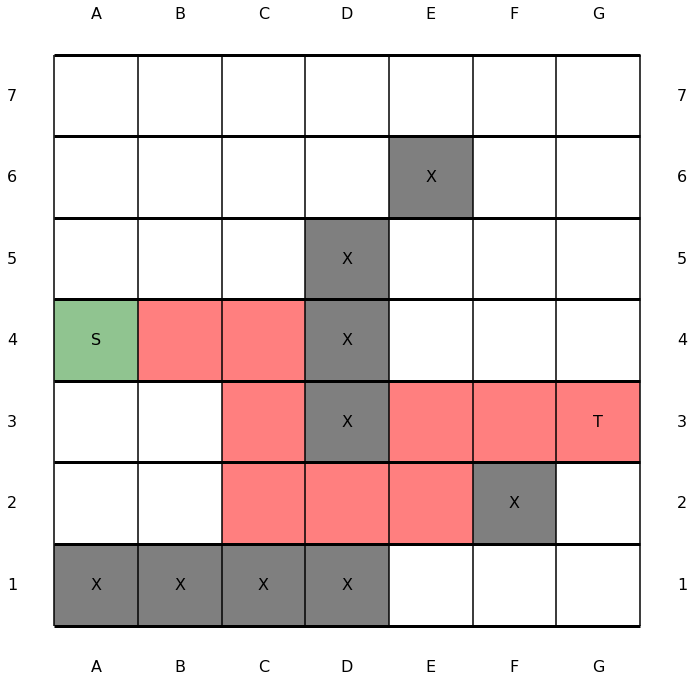

In [18]:
# Each square's neighbors are discovered in order: Top - right - bottom - left
# If multiple squares have the same distances towards the target,, then the square to be visited is picked in FIFO order

create_grid()

# Set start and target (Note that square names match the naming scheme of chess boards).
# The bottom row would consist of (left to right): 'A1', 'B1', 'C1', etc.
# The leftmost column would consist of (bottom to top): 'A1', 'A2', 'A3', etc.
start, target = set_start_target('A4', 'G3')

set_obstacles(['A1', 'B1', 'C1', 'D1', 'D3', 'D4', 'D5', 'E6', 'F2'])

a_star(start, target)

show_legend()
# Display each image of the pathfinding process
for i in range(0, len(grid_states)):
    visualize(grid_states[i], i)
# Displaying the route from start to end
visualize(grid_states[i], -1)
# Reset results for next test
grid_states = []
color_states = [[]]

## Adjust grid size and HEURISTIC_BIAS here 

In [19]:
AMT_ROWS = 9
AMT_COLS = 9

HEURISTIC_BIAS = True

## Yet another example

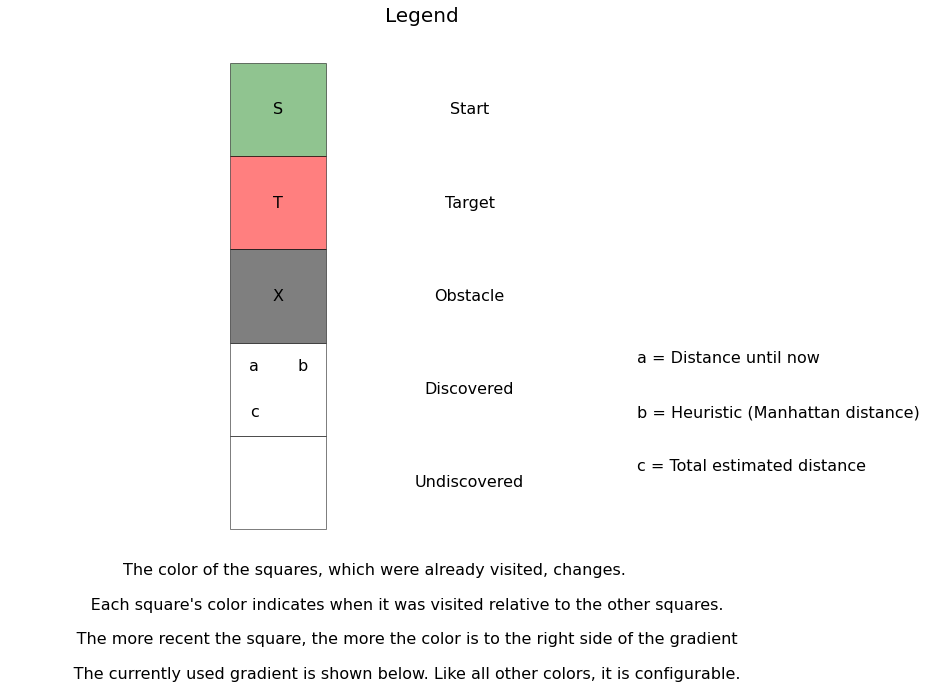

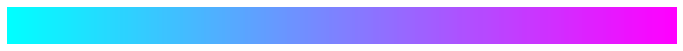

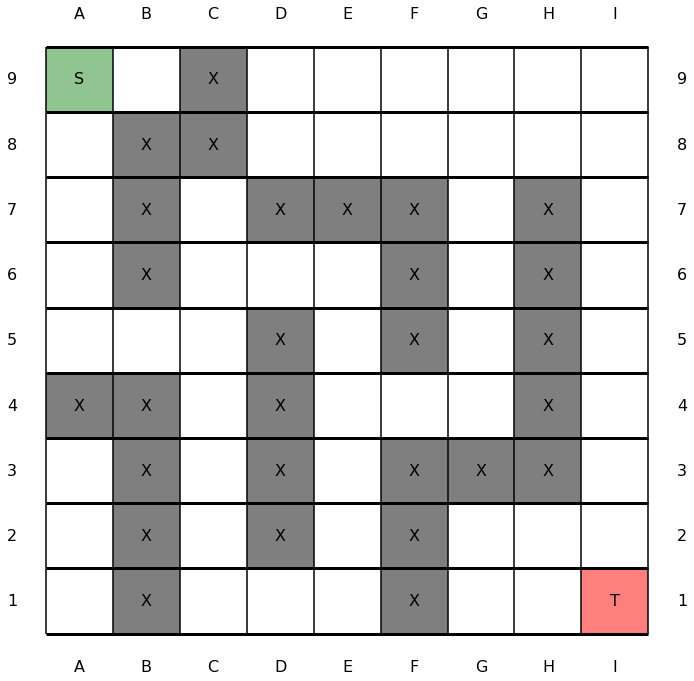

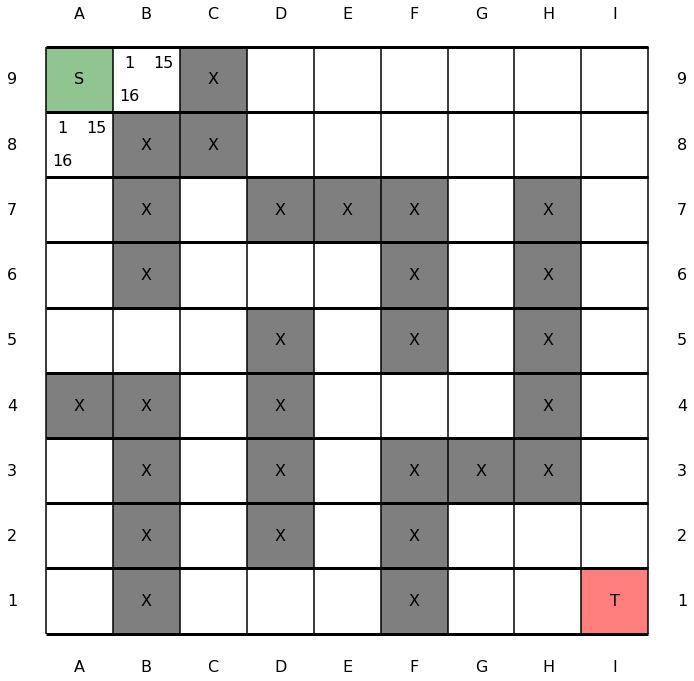

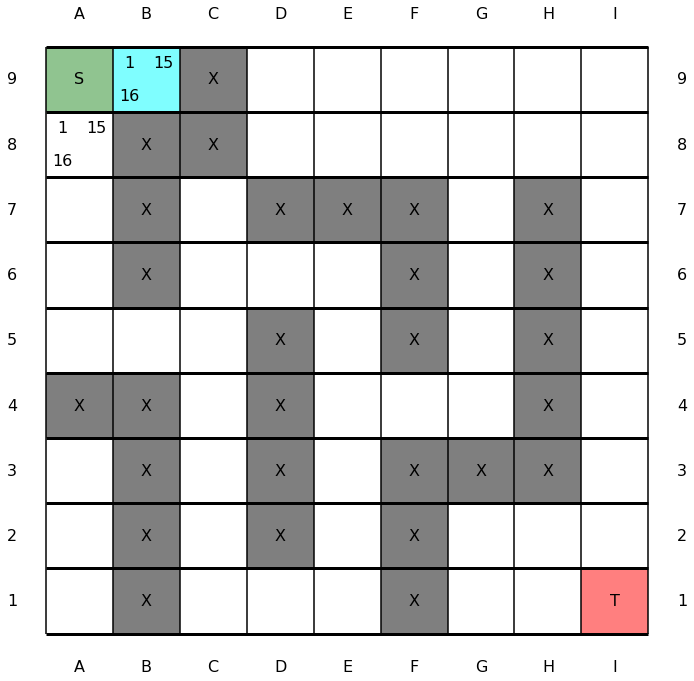

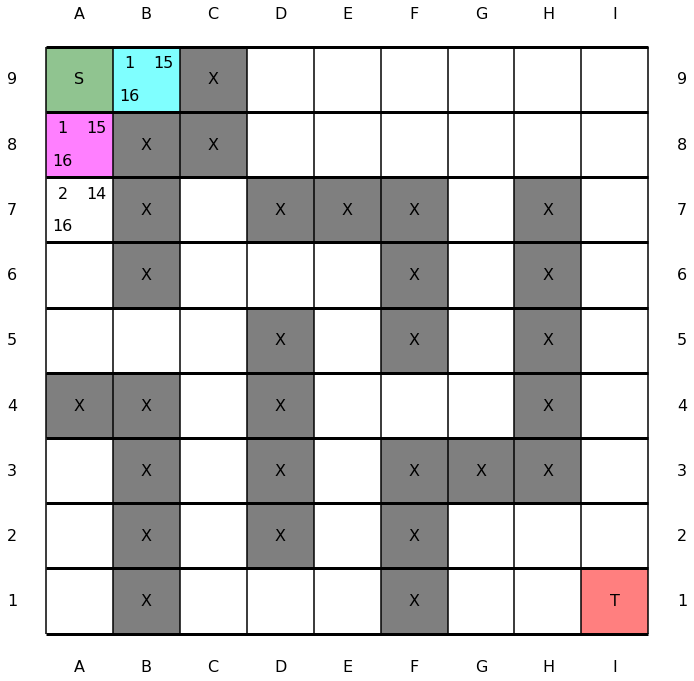

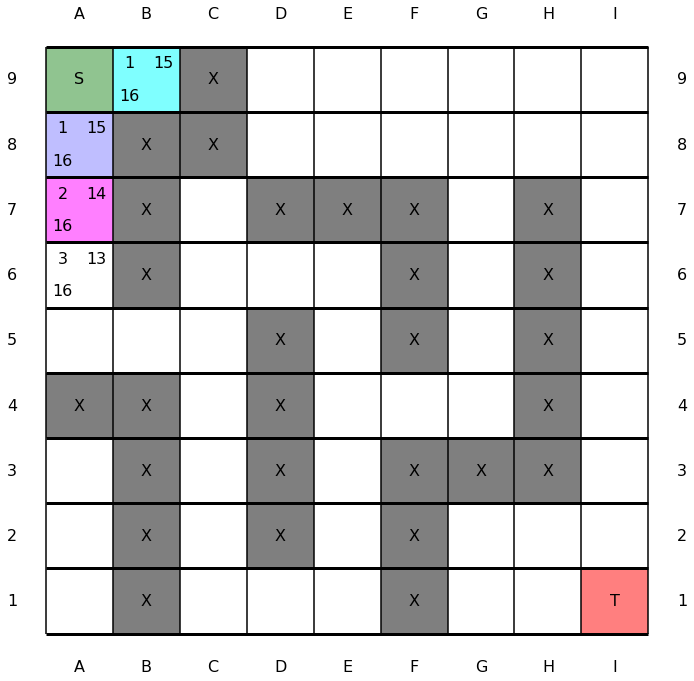

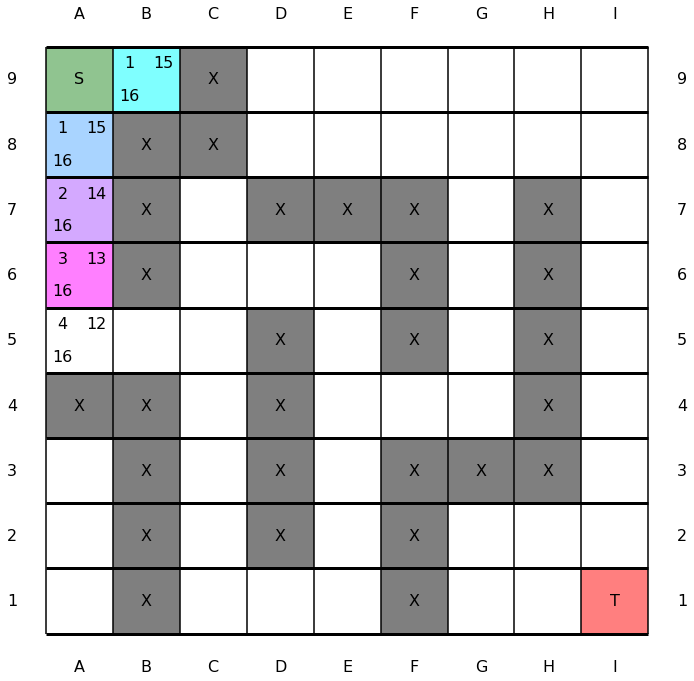

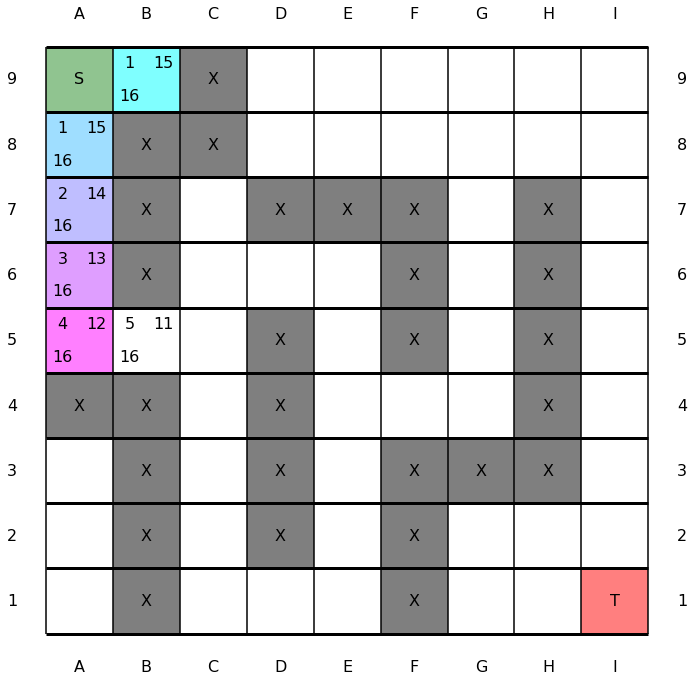

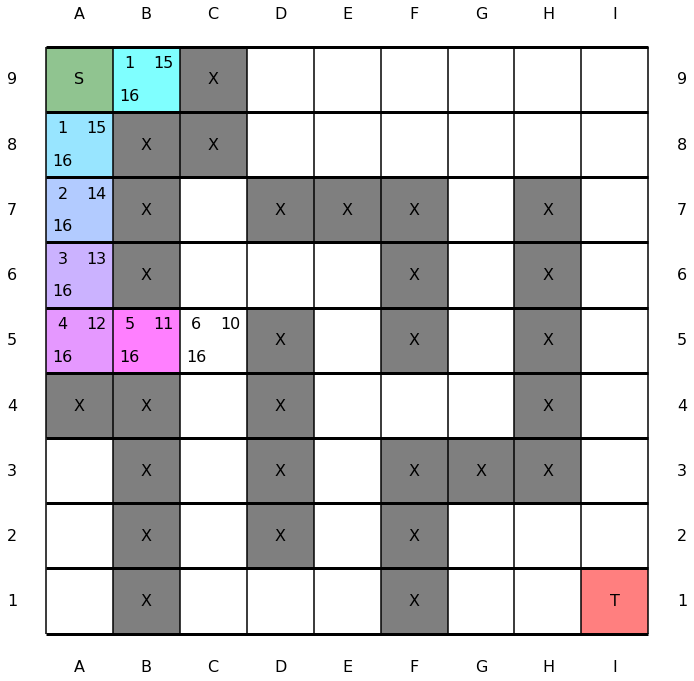

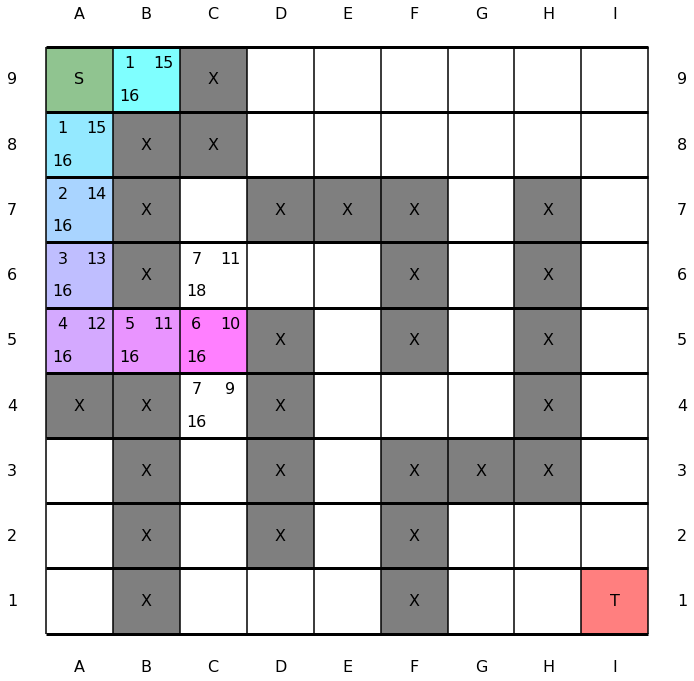

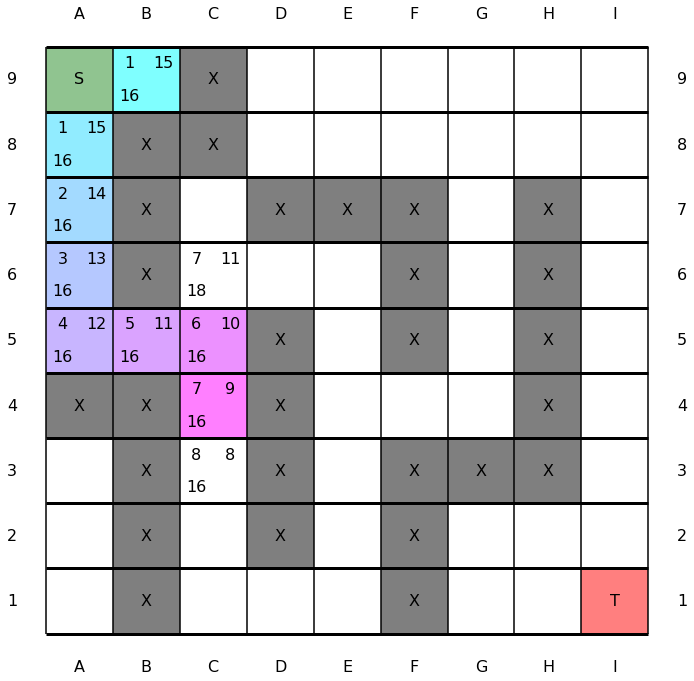

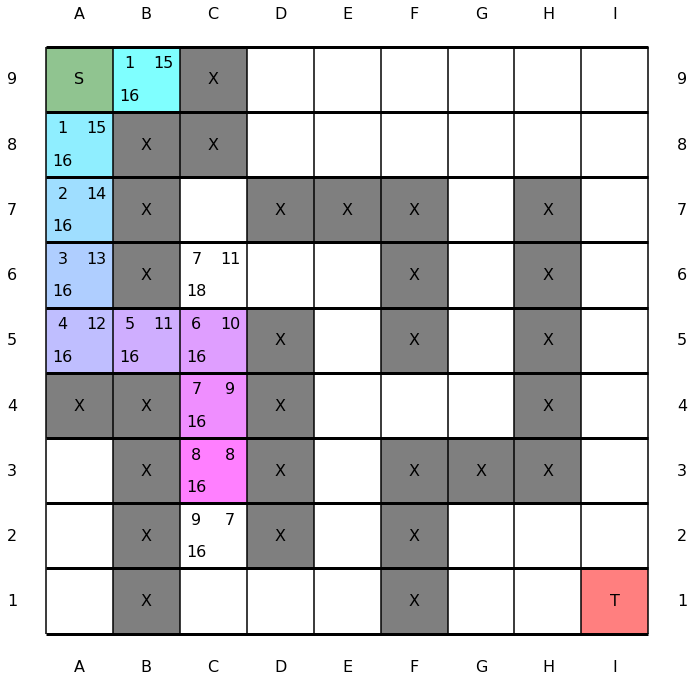

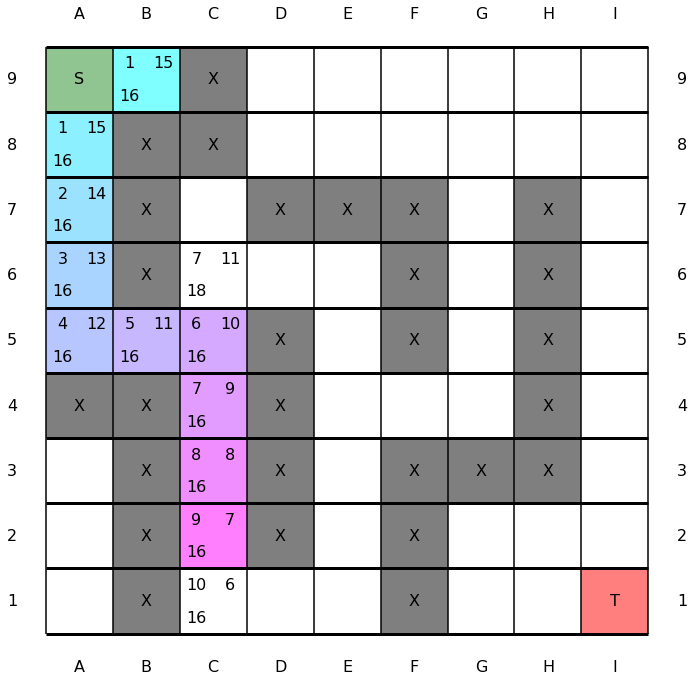

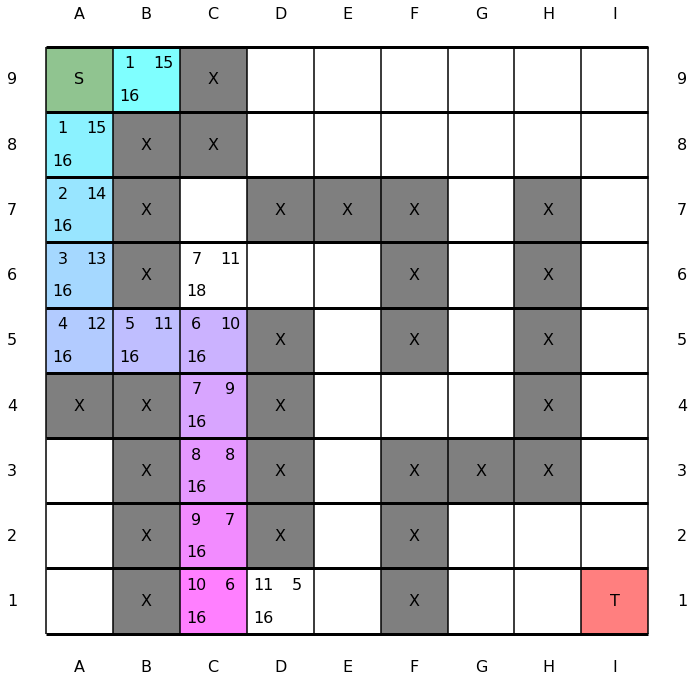

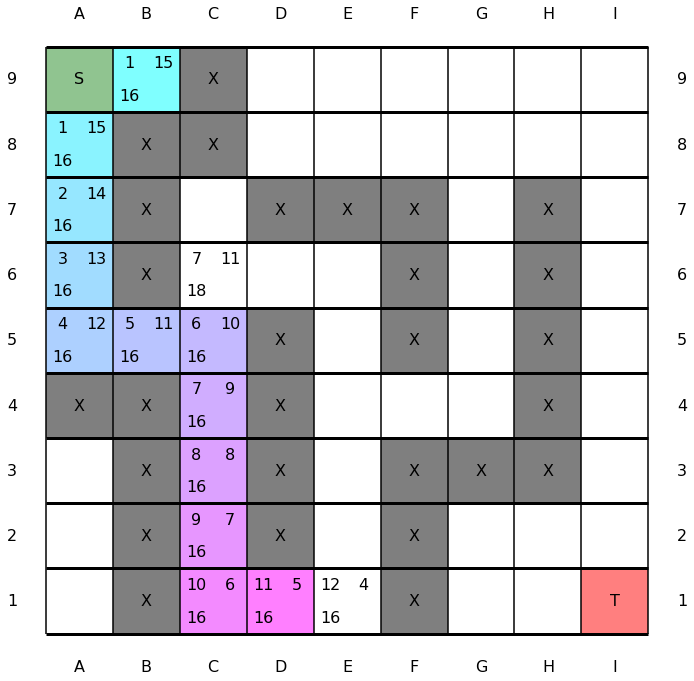

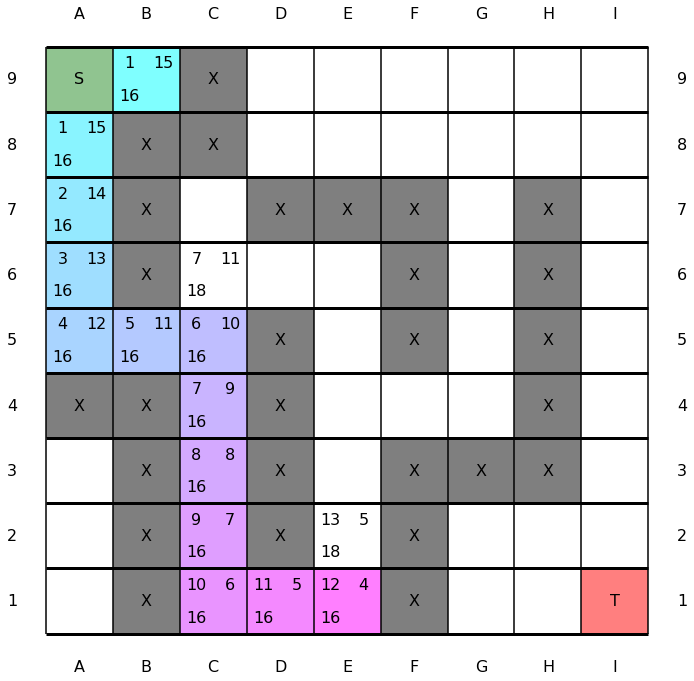

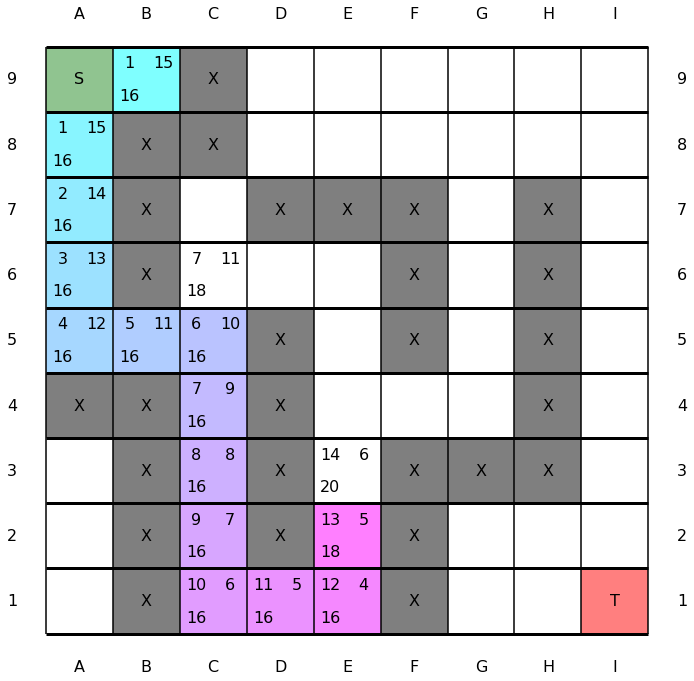

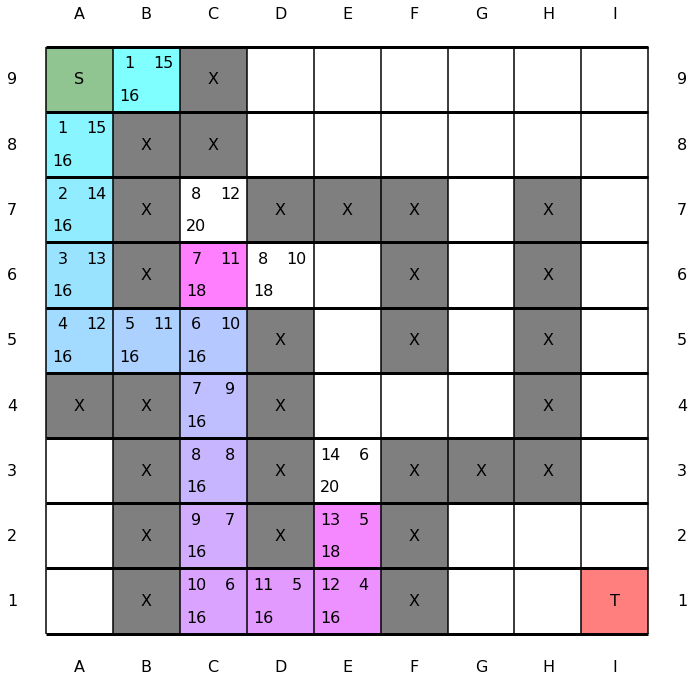

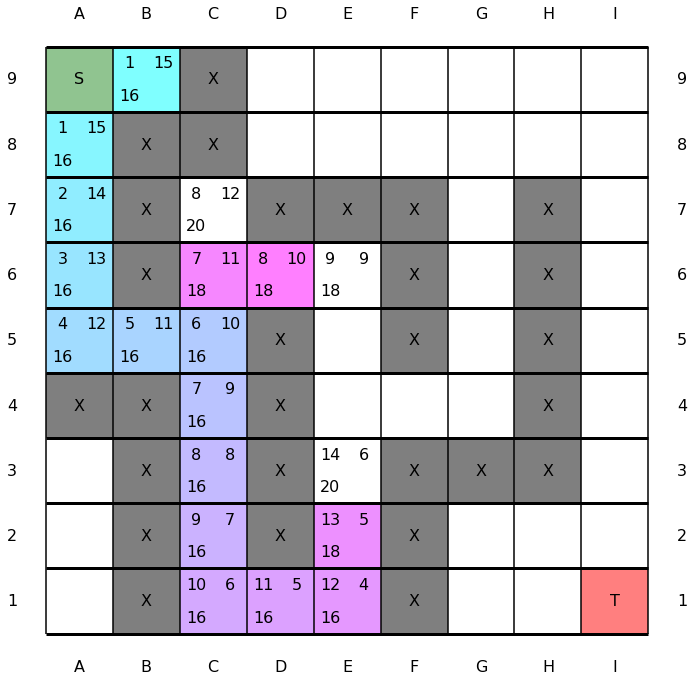

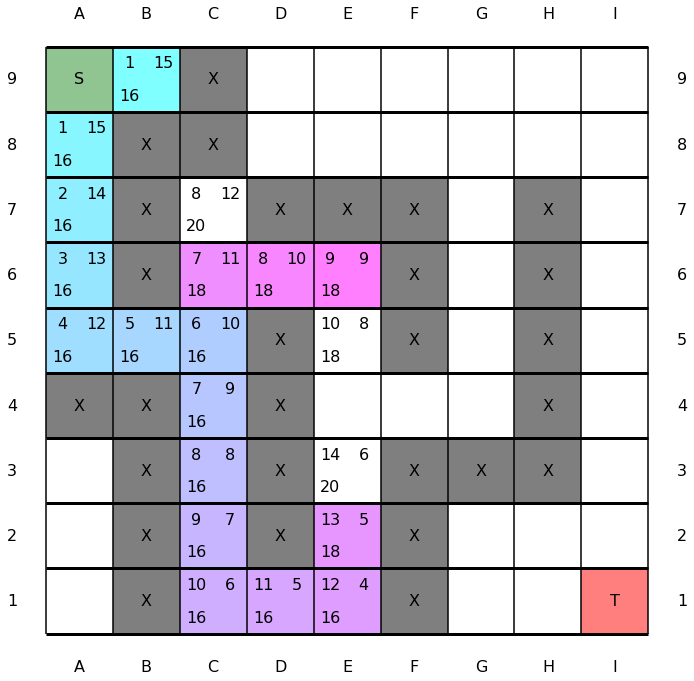

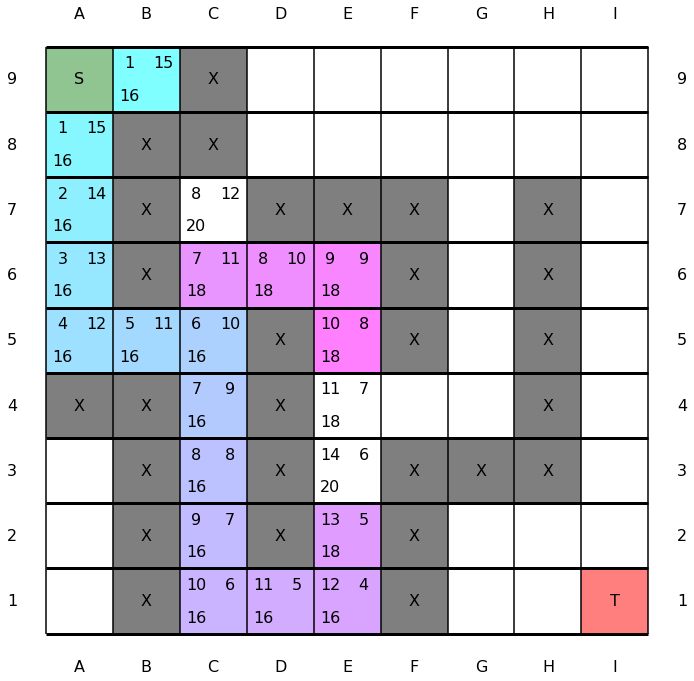

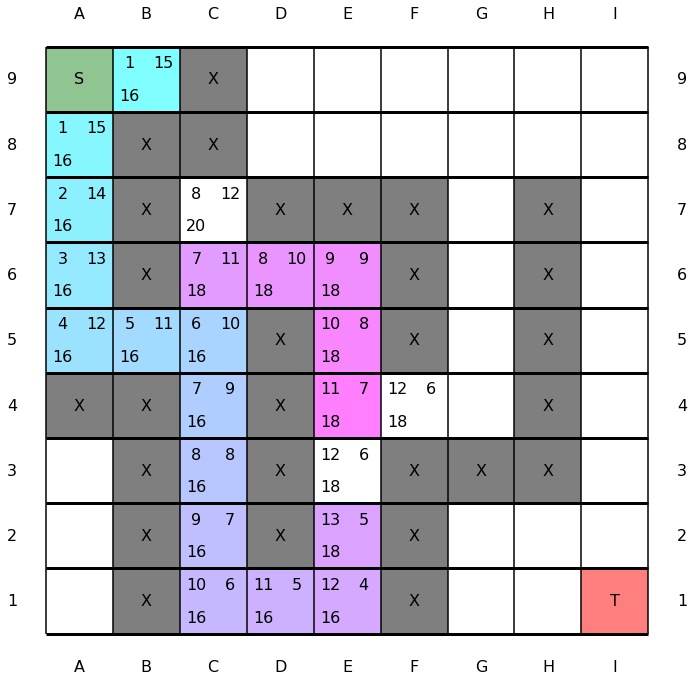

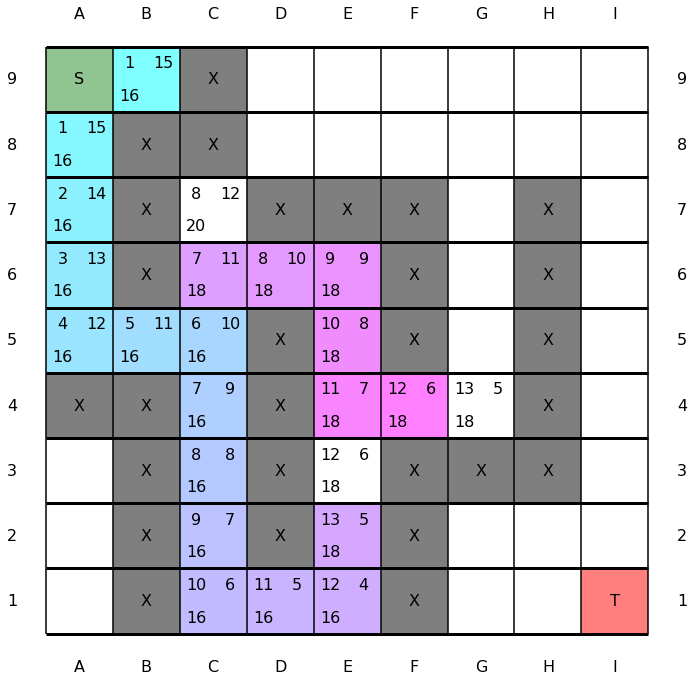

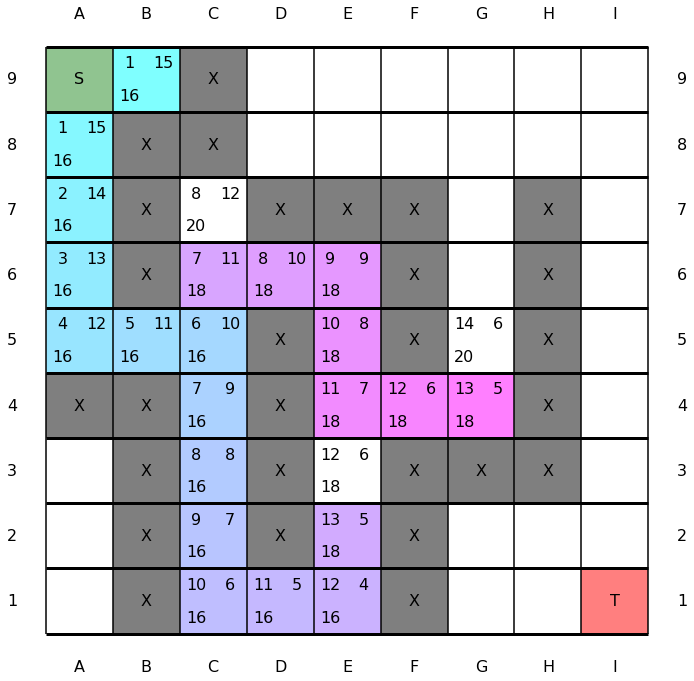

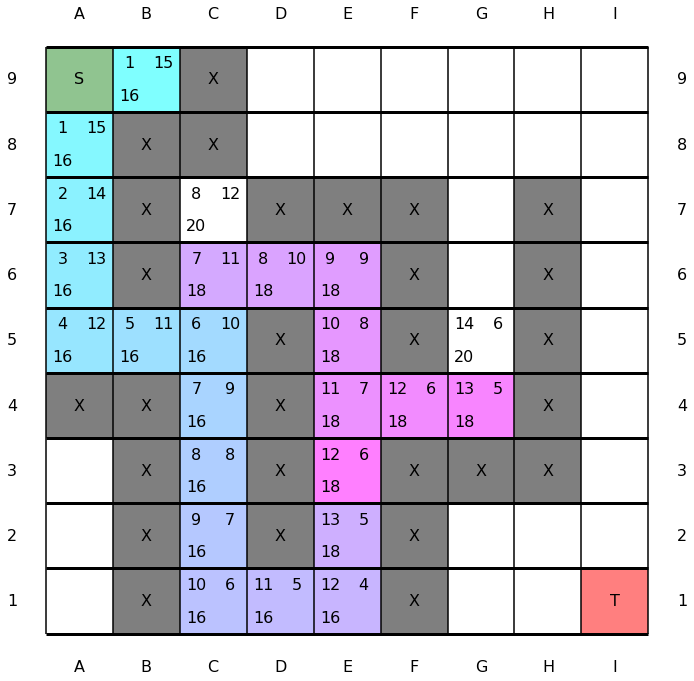

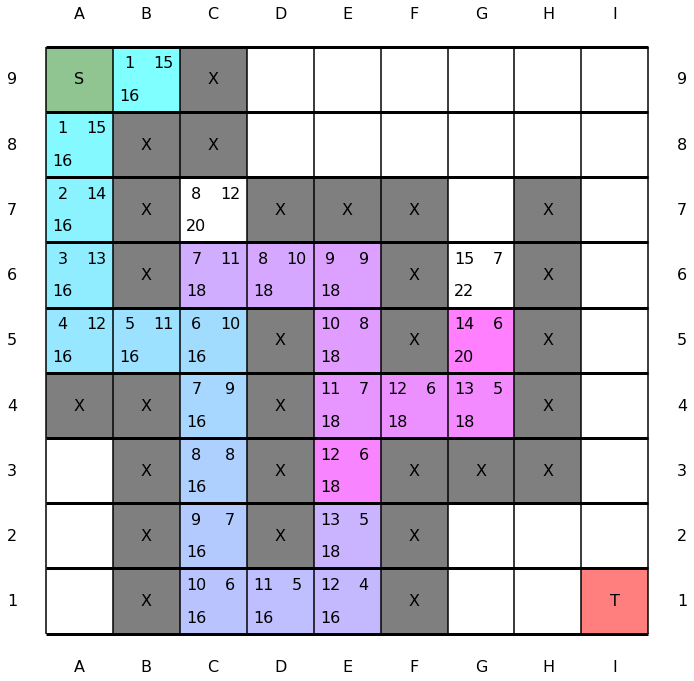

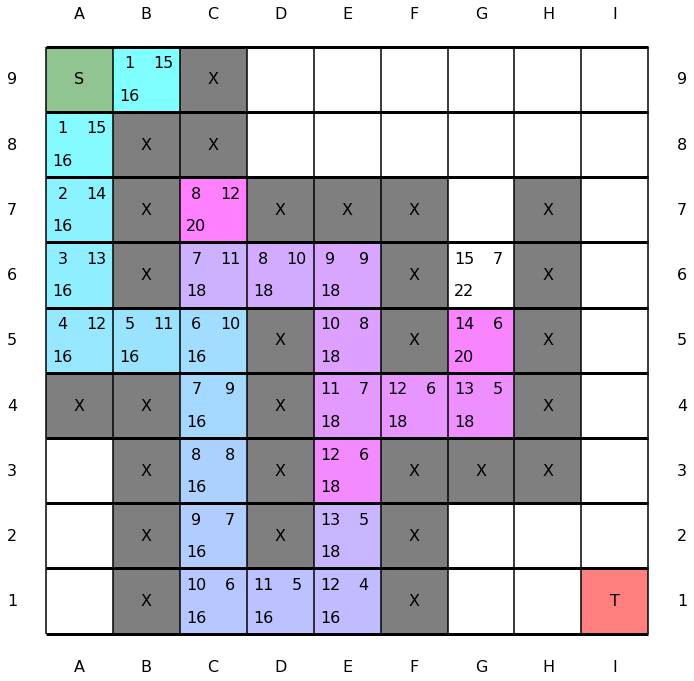

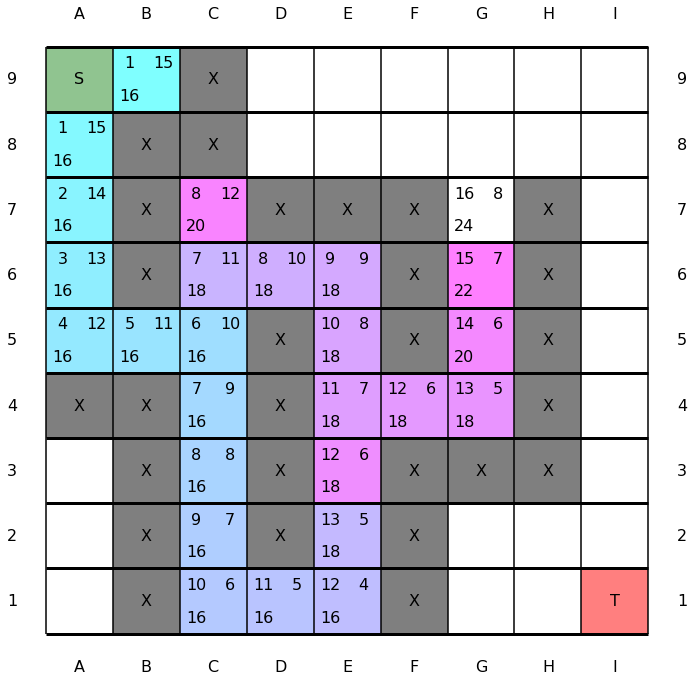

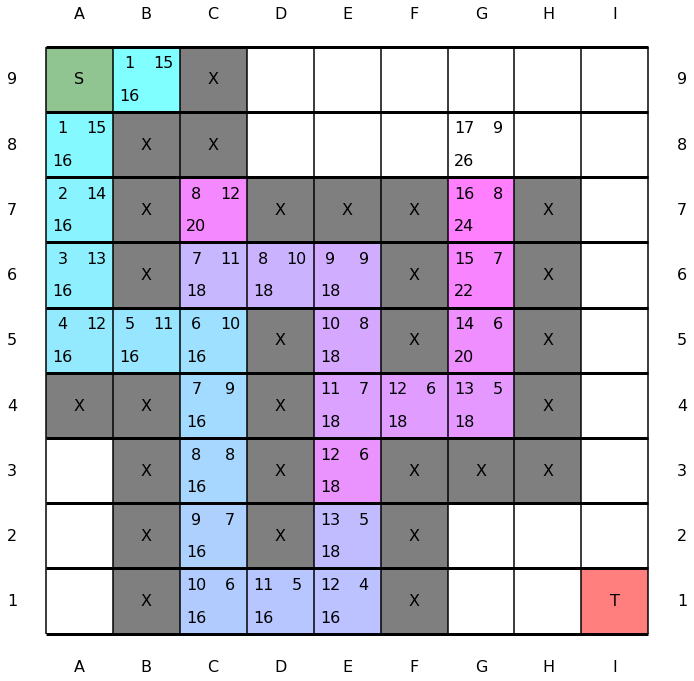

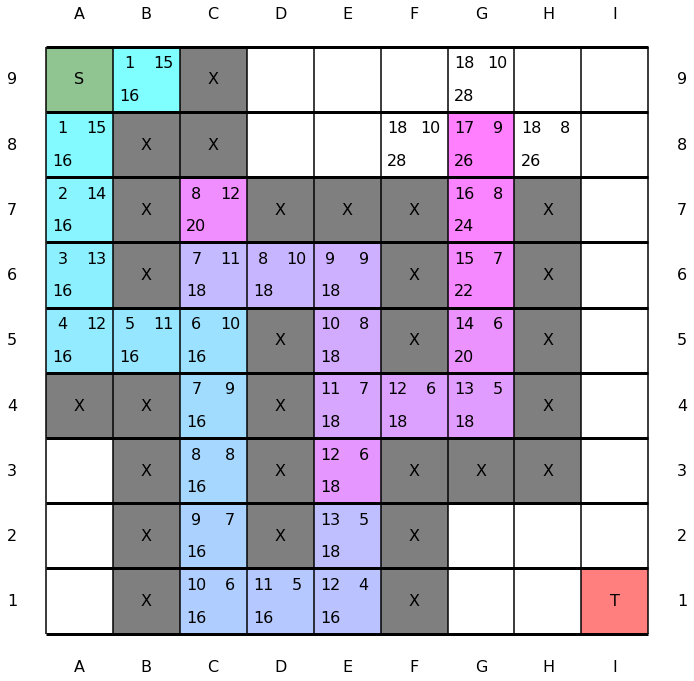

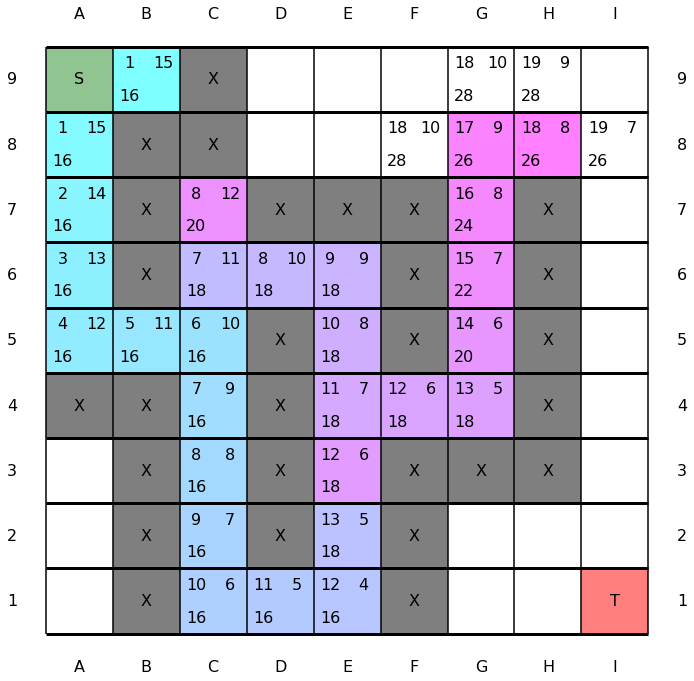

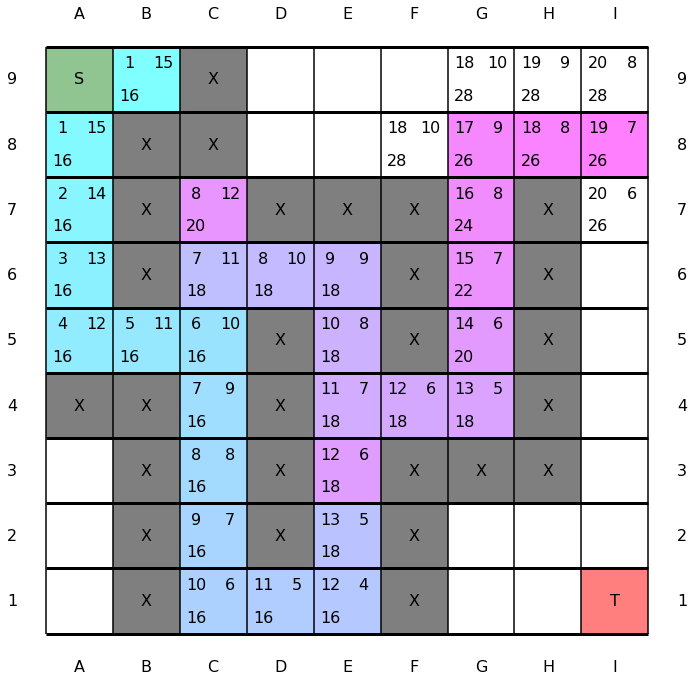

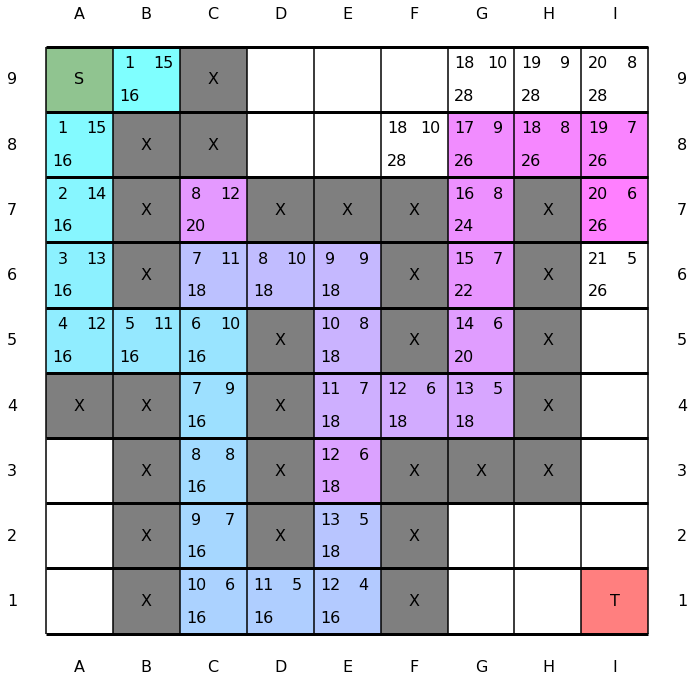

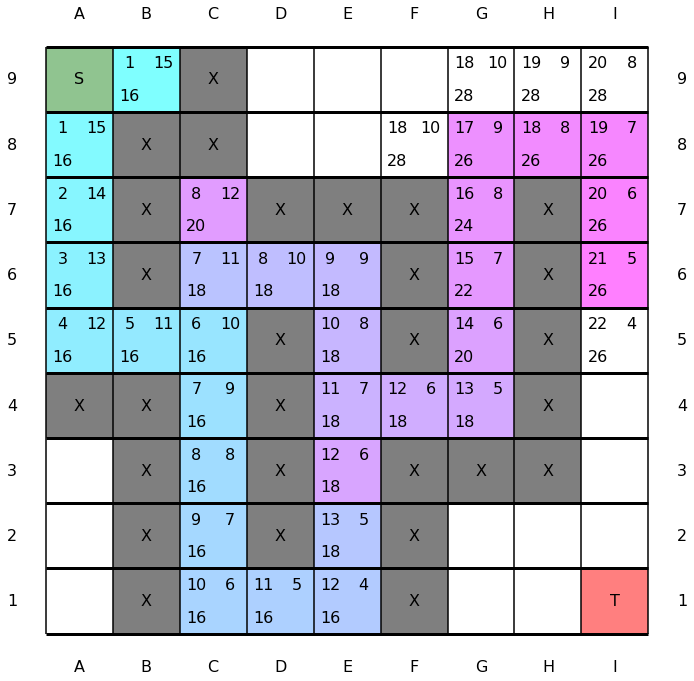

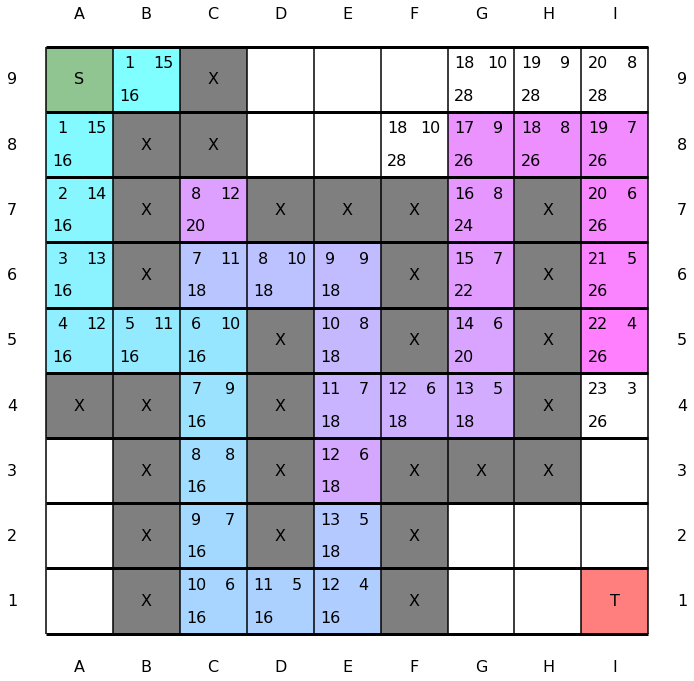

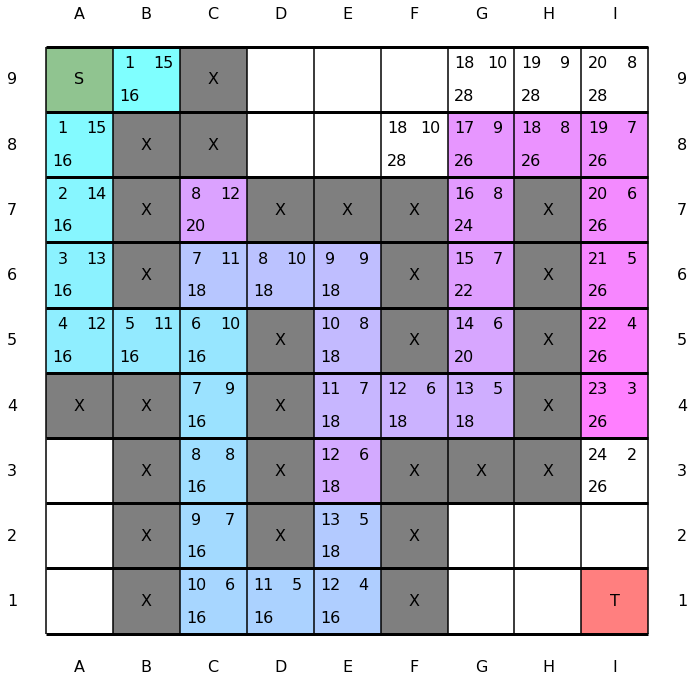

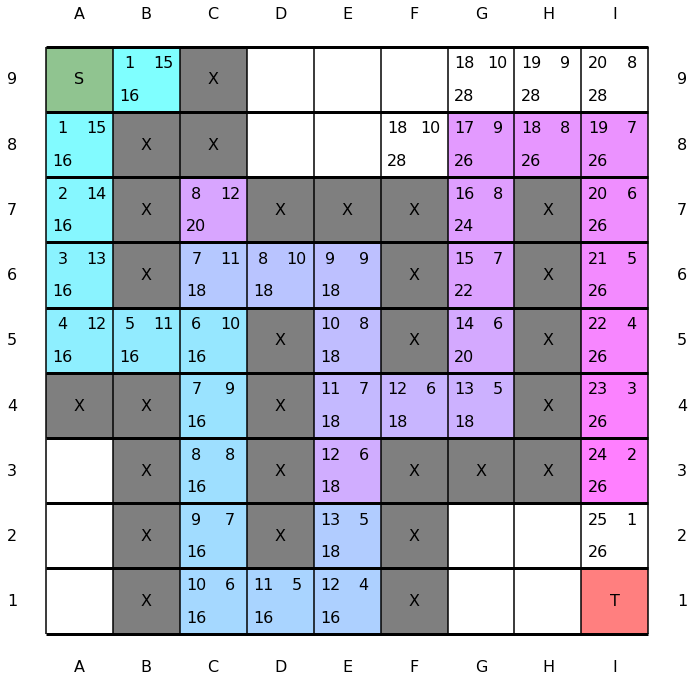

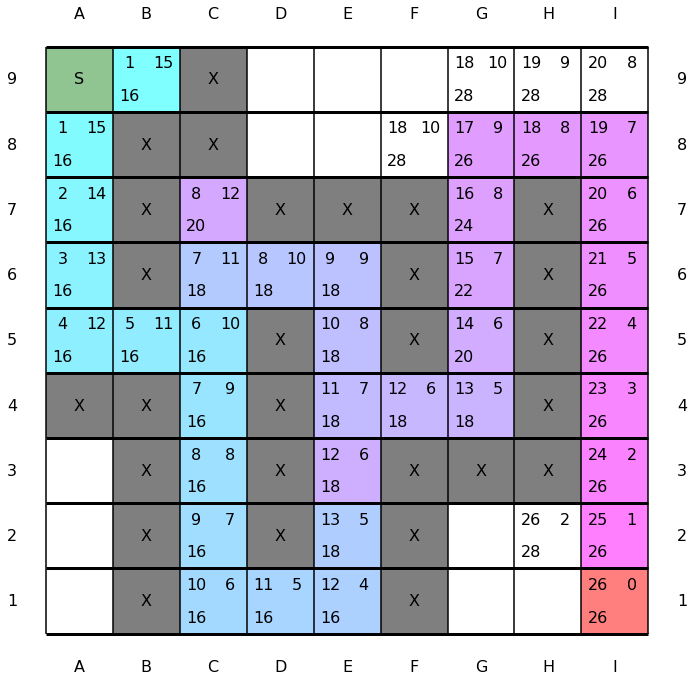

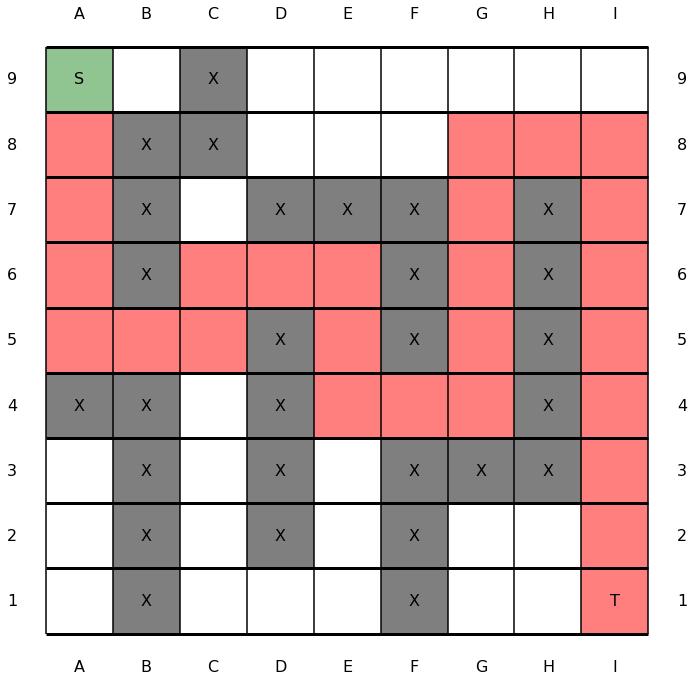

In [20]:
create_grid()

start, target = set_start_target('A9', 'I1')

set_obstacles(['A4', 'B1', 'B2', 'B3', 'B4', 'B6', 'B7', 'B8', 'C8', 'C9', 'D2', 'D3', 'D4', 'D5', 'D7', 
               'E7', 'F1', 'F2', 'F3', 'F5', 'F6', 'F7', 'G3', 'H3', 'H4', 'H5', 'H6', 'H7'])

a_star(start, target)

show_legend()
for i in range(0, len(grid_states)):
    visualize(grid_states[i], i)
visualize(grid_states[i], -1)
# Reset results for next test
grid_states = []
color_states = [[]]

## Adjust grid size and HEURISTIC_BIAS here 

In [21]:
AMT_ROWS = 7
AMT_COLS = 7

HEURISTIC_BIAS = True

## Your tests go here...

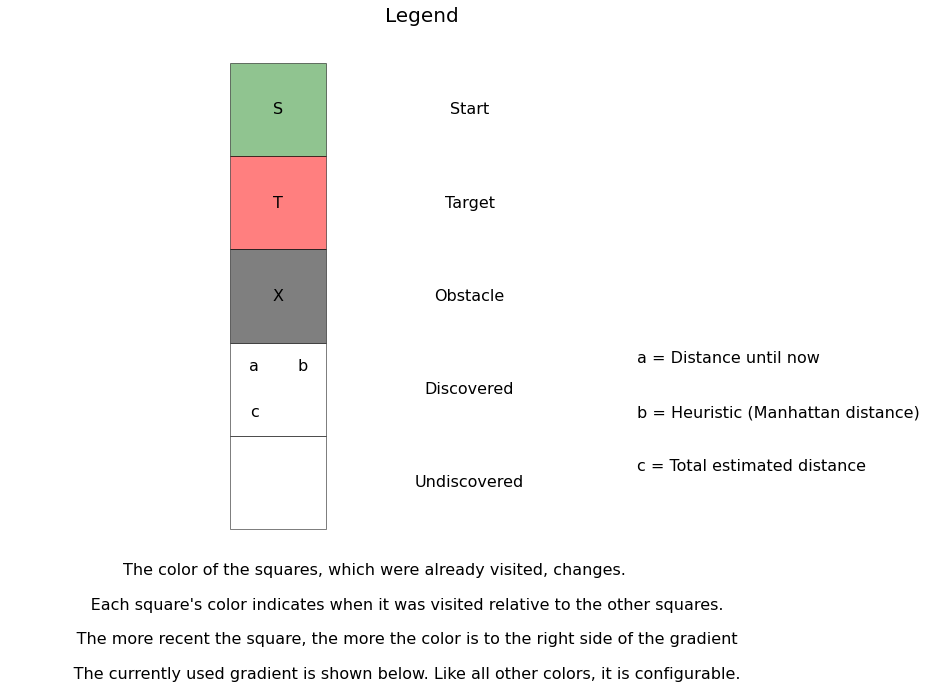

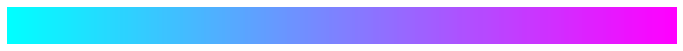

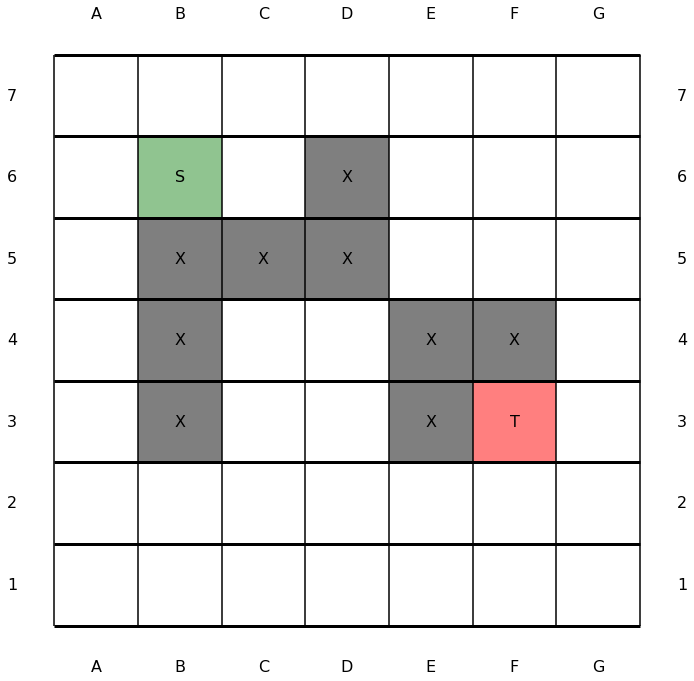

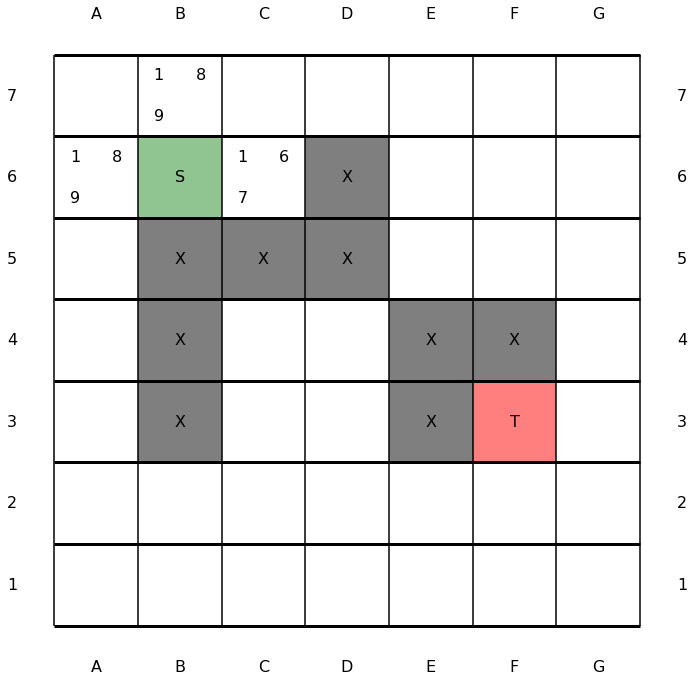

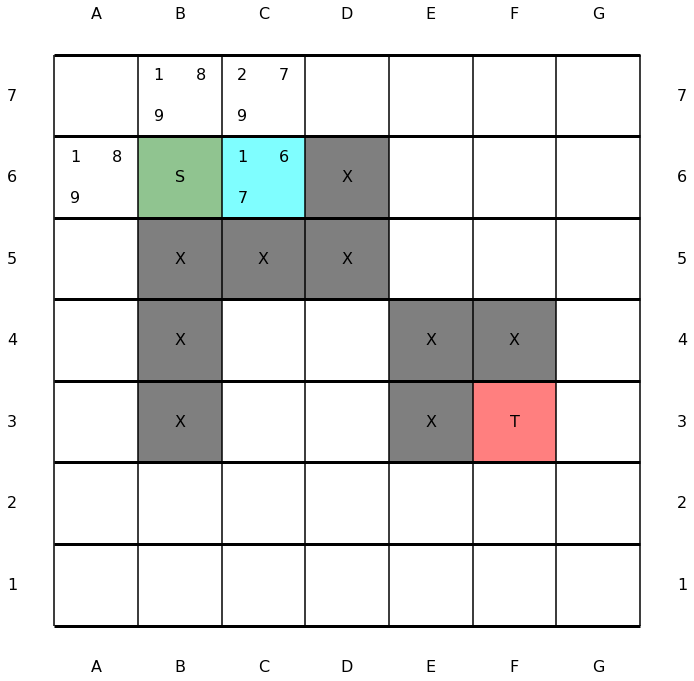

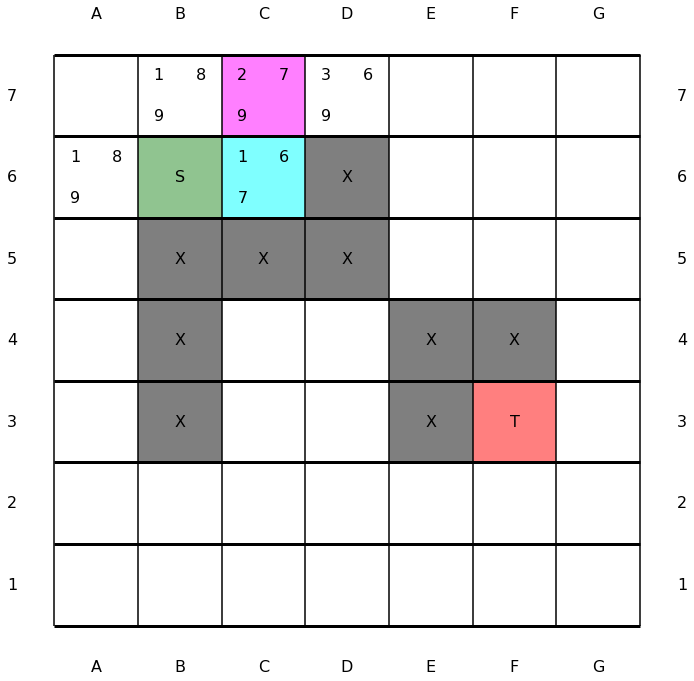

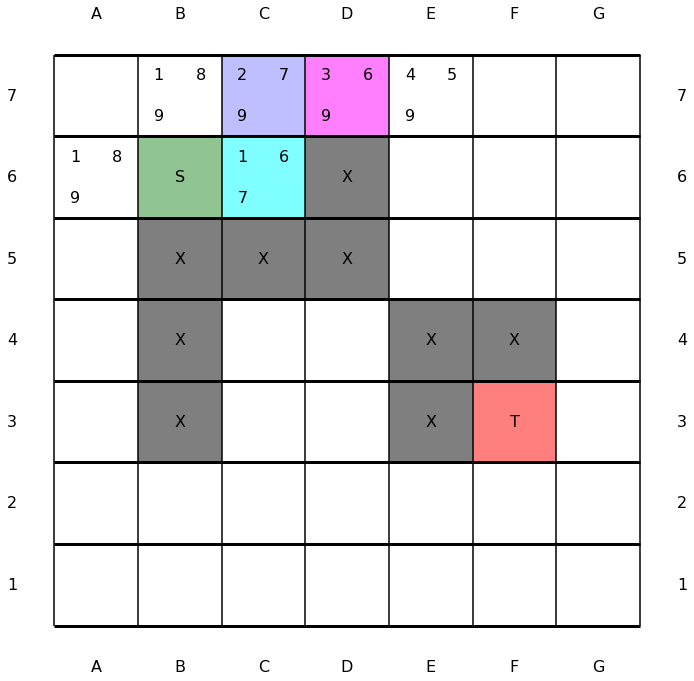

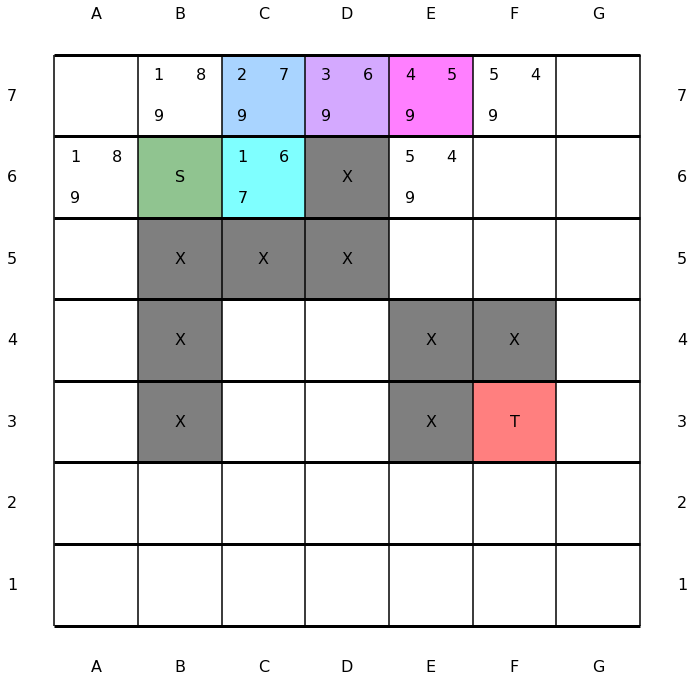

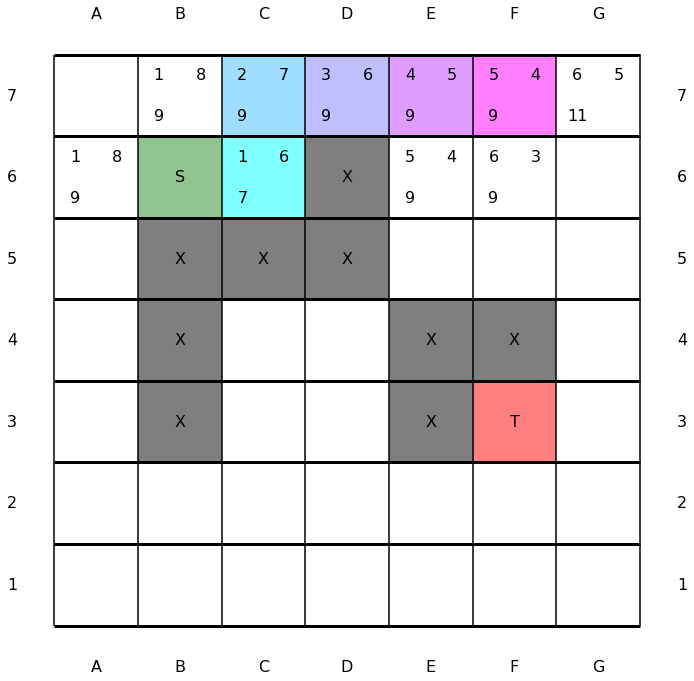

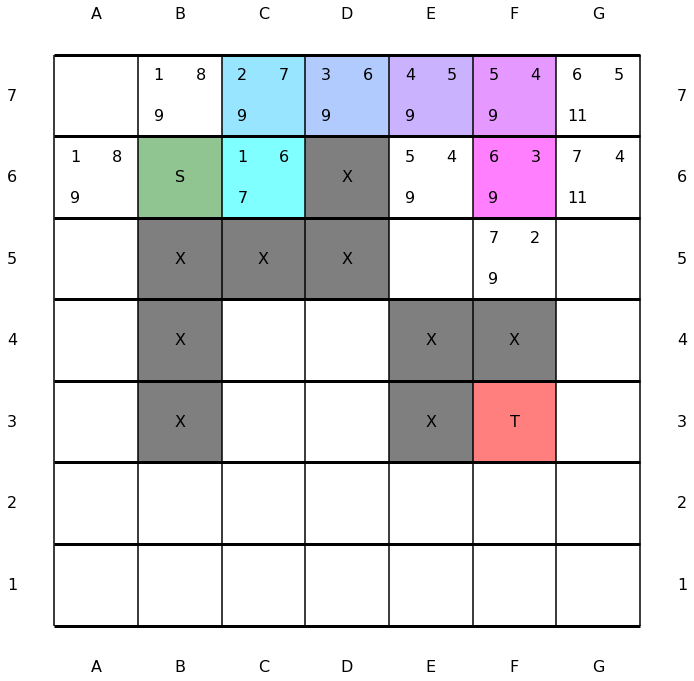

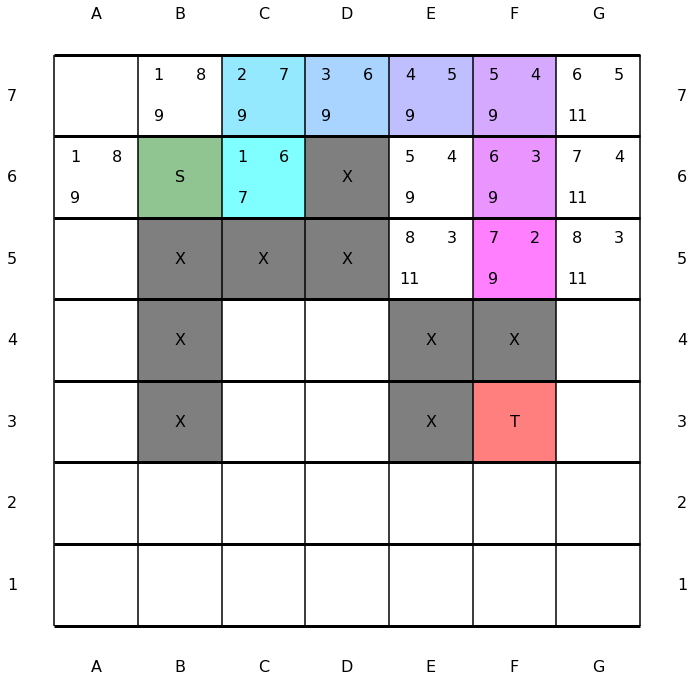

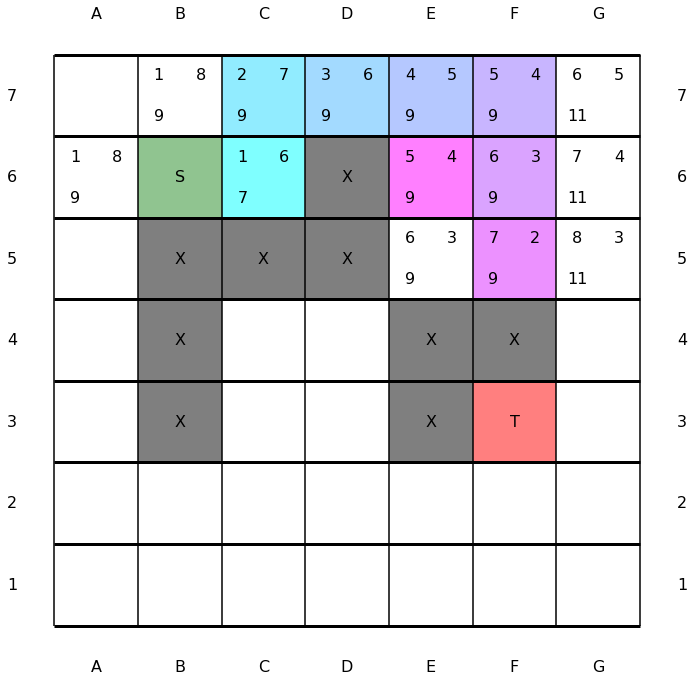

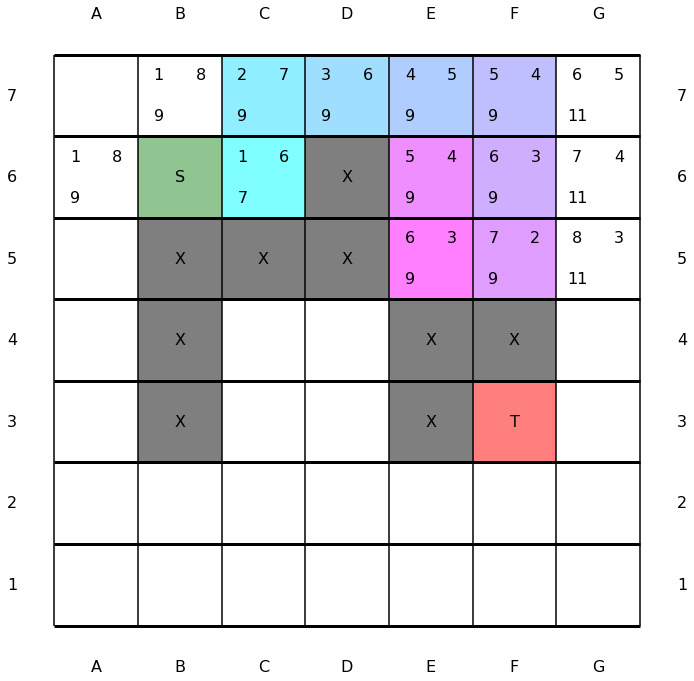

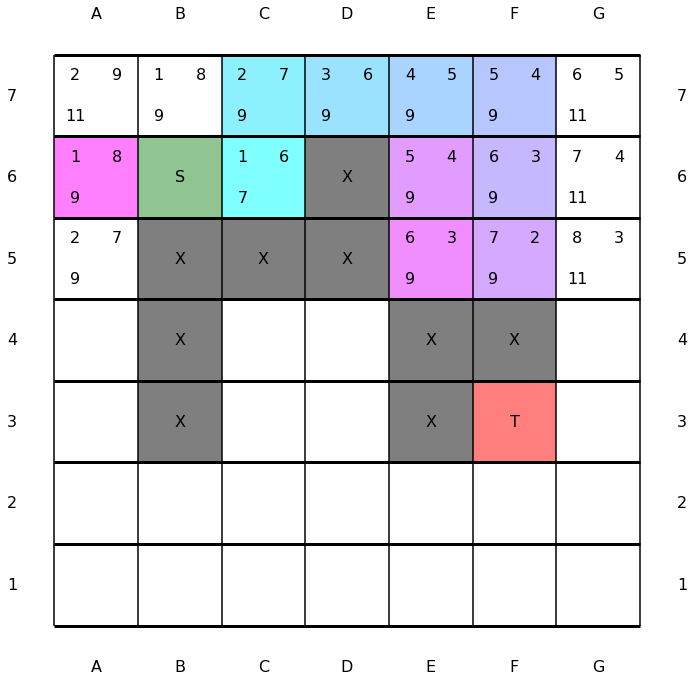

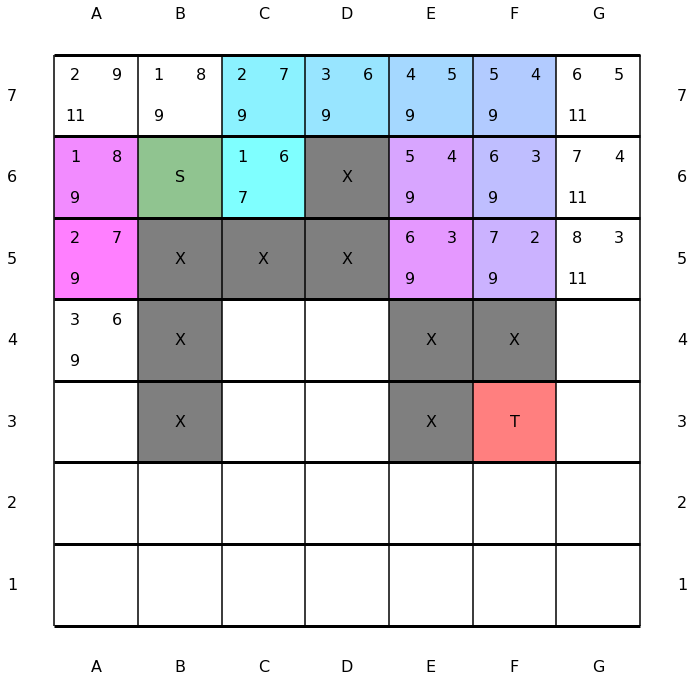

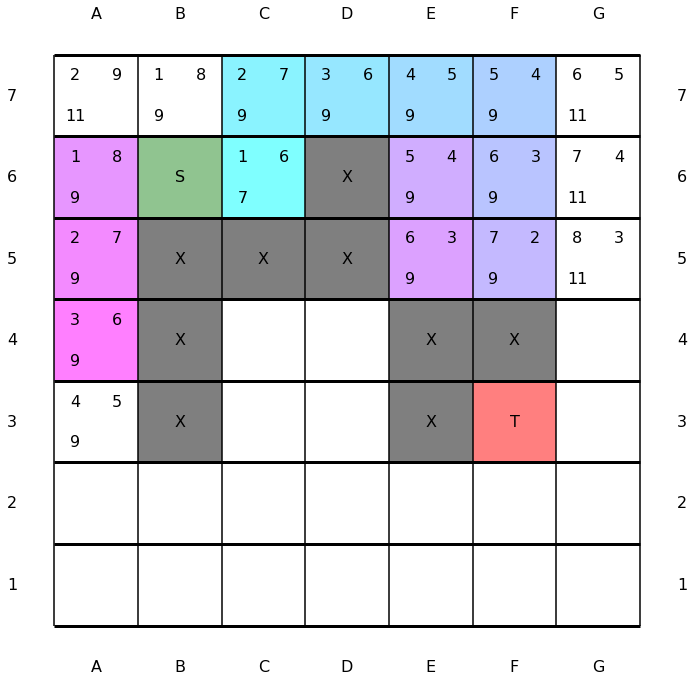

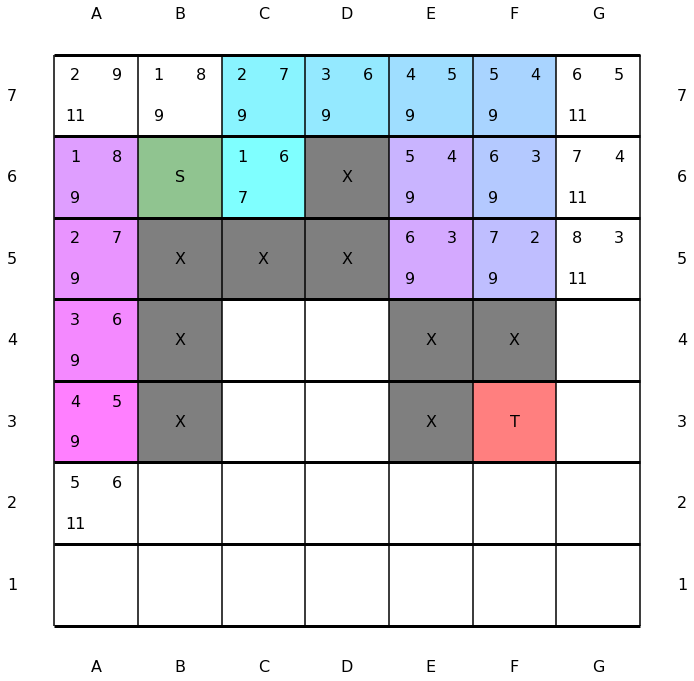

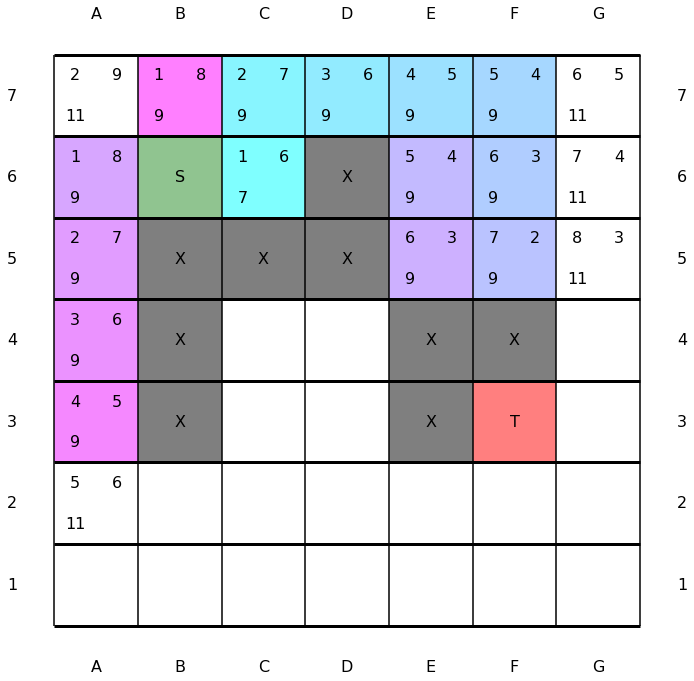

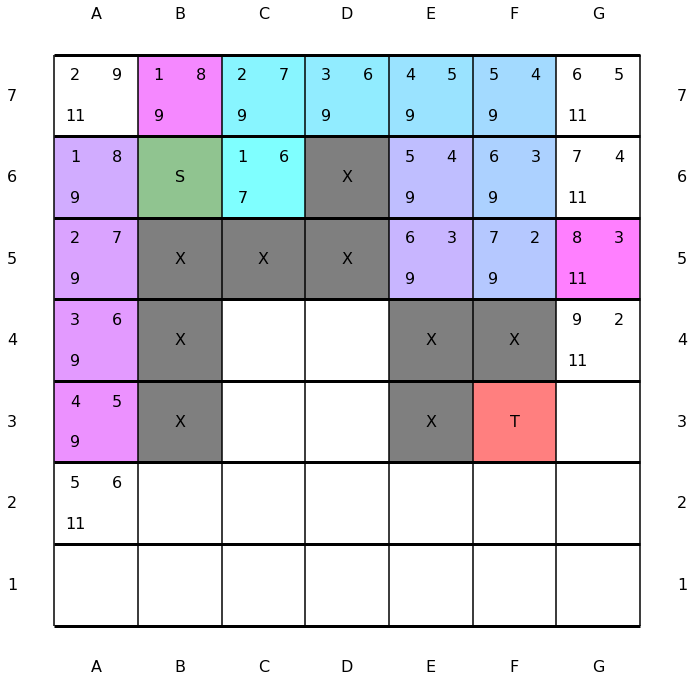

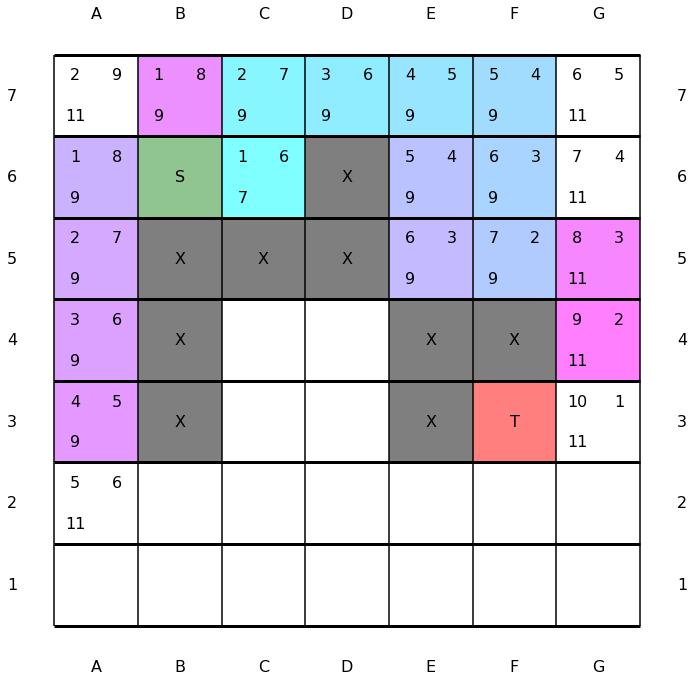

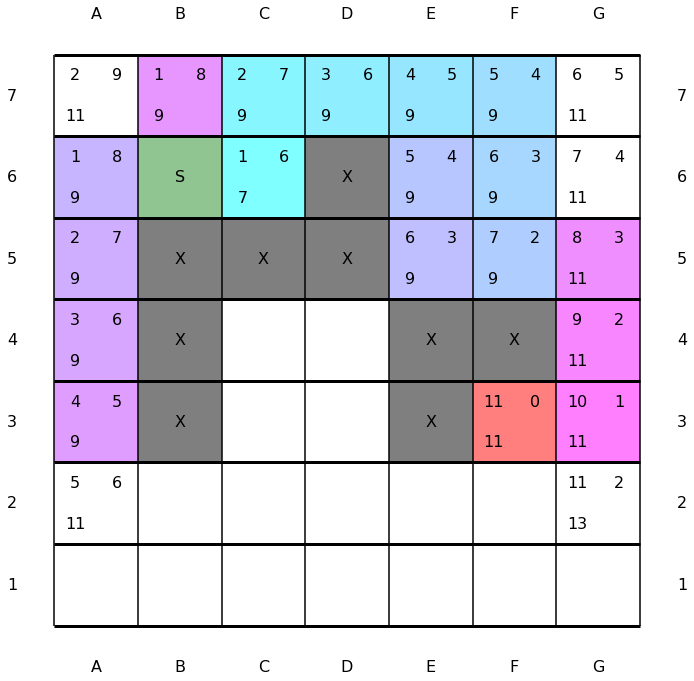

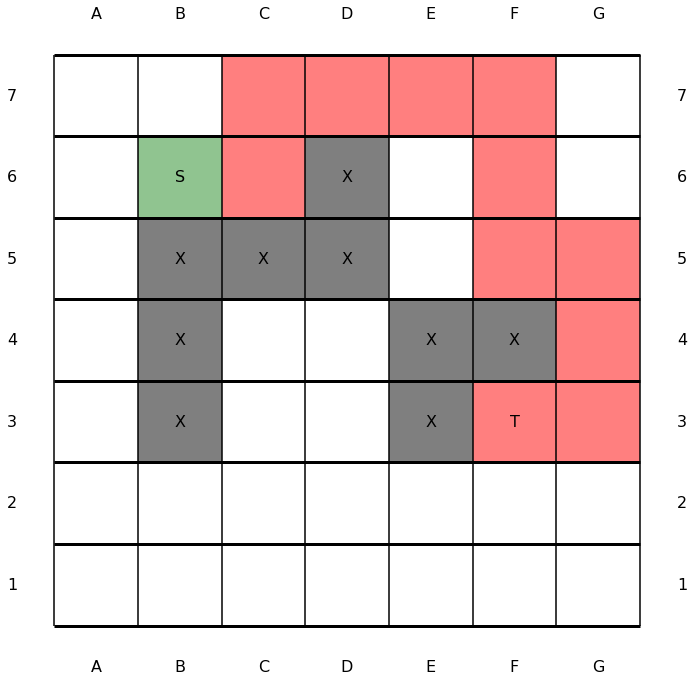

In [22]:
create_grid()

start, target = set_start_target('B6', 'F3')

set_obstacles(['B3', 'B4', 'B5', 'C5', 'D5', 'D6', 'E3', 'E4', 'F4'])

a_star(start, target)

show_legend()
for i in range(0, len(grid_states)):
    visualize(grid_states[i], i)
visualize(grid_states[i], -1)
# Reset results for next test
grid_states = []
color_states = [[]]